In [85]:
import sys
import os
import subprocess
import re
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import getpass
import matplotlib as mpl
import argparse
import glob
import traceback
import hashlib
import math
import collections
import functools

import sklearn.preprocessing
import sklearn.feature_selection
import sklearn.ensemble 
import sklearn.neural_network
import sklearn.model_selection
import sklearn.metrics
import sklearn.pipeline
from sklearn.externals import joblib

# mpl.use('Agg')
mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt
import seaborn as sns

In [86]:
app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import event_processing_v3
import event_processing_v4
import postgresql_v3_event_storage
import dataset_query_functions_v3

import tool.acqconv
from data_analysis_utils import *
from data_analysis_utils_dataframes import *
from data_analysis_utils_trigger_rate import *
# import supervised_classification as supc    

In [87]:
inverse_means_map = np.load('/home/spbproc/euso-spb-patt-reco-v1/resources/inverse_flat_average_directions_4m_flipud.npy')

In [88]:
classification_id = '201906122'
model_data_snippets_dir = 'ver4_machine_learning_w_labeled_flight_' + classification_id
data_snippets_dir = 'ver4_machine_learning_flight_classification_tsne_cfg3_' + classification_id

subset_classification_slug = 'ver4_ml_tsne_cfg3_' + classification_id

os.makedirs(data_snippets_dir, exist_ok=True)

# Selecting the flight data

In [89]:
event_processing_cls = event_processing_v4.EventProcessingV4
event_v3_storage_provider_flight = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_w_flatmap.ini'), 
    table_names_version='ver4',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls,
    readonly=False
)

query_functions_flight = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider_flight)

## Columns

In [90]:
rfecv_selector_on_extra_trees__column_names = []

columns_list_file_pathname = os.path.join(model_data_snippets_dir, 'rfecv_selector_on_extra_trees__column_names.txt')
print(columns_list_file_pathname)
with open(columns_list_file_pathname, 'r') as columns_list_file:
    rfecv_selector_on_extra_trees__column_names = columns_list_file.read().splitlines()

ver4_machine_learning_w_labeled_flight_201906122/rfecv_selector_on_extra_trees__column_names.txt


In [91]:
rfecv_selector_on_extra_trees__column_names__special = []

special_columns_list_file_pathname = os.path.join(model_data_snippets_dir, 'rfecv_selector_on_extra_trees__column_names__special.txt')
print(special_columns_list_file_pathname)
with open(special_columns_list_file_pathname, 'r') as special_columns_list_file:
    rfecv_selector_on_extra_trees__column_names__special = special_columns_list_file.read().splitlines()

ver4_machine_learning_w_labeled_flight_201906122/rfecv_selector_on_extra_trees__column_names__special.txt


In [92]:
# This should be empty for now
rfecv_selector_on_extra_trees__column_names__special

[]

In [93]:
flight_columns_for_analysis_dict = query_functions_flight.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=[
        ('^$','source_file_(acquisition|trigger)(_full)?|global_gtu|packet_id|gtu_in_packet|event_id|num_gtu'),
        ('gps_datetime_min')
    ] + rfecv_selector_on_extra_trees__column_names
)

classification_flight_columns_for_analysis_dict = query_functions_flight.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=rfecv_selector_on_extra_trees__column_names
)

print_columns_dict(flight_columns_for_analysis_dict)

spb_processing_v4_flatmap.event
	- event_id
	- source_file_acquisition_full
	- source_file_trigger_full
	- source_file_acquisition
	- source_file_trigger
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu

spb_processing_v4_flatmap.event_trg_box_per_gtu
	- max
	- mean
	- mean_gz

spb_processing_v4_flatmap.event_trg_pmt_per_gtu
	- max
	- mean
	- mean_gz

spb_processing_v4_flatmap.event_trg_ec_per_gtu
	- mean
	- mean_gz

spb_processing_v4_flatmap.event_gps_datetime
	- min

spb_processing_v4_flatmap.event_trg_x_y_clusters
	- sizes_max
	- max_size_clu_width
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height
	- max_peak_clu_size

spb_processing_v4_flatmap.event_trg_gtu_y_clusters
	- max_peak_clu_height

spb_processing_v4_flatmap.event_orig_x_y
	- sum
	- max
	- mean
	- mean_gz

spb_processing_v4_flatmap.event_proc1_x_y_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_width
	- max_peak_clu_width
	- max_peak_clu_size

spb_processing_v4_flatmap.e

WARNING: not selecting NULL trg lines

## Event classes

In [95]:
EVENT_CLASSES = {
    'pixel': 2,
    'top_left_ec': 5,
    'blob': 12,
    'large_blob': 11,
    'short_single_gtu_track': 7,
    'single_gtu_track': 3,
    'noise': 1,
    'cartesian_line': 4,
    'strong_pmt_edge': 9,
    'few_dots': 6,
    'bg_increased_suddenly': 10,
    'persistent_dot': 14,
    'noise_unspecified': 0,
    'unspecified': 8,
    'shower': 13,
    '2pix_line': 15,
    'bright_blob': 16,
    'blob_and_dots': 17,
    'dot_w_blob_behind': 18,
    'storng_light': 19,
    'sparse_blobs': 20,
    'noise_with_week_dot': 21,
    #
    'unclassified': -1
}

In [96]:
len(EVENT_CLASSES)

23

In [97]:
INVERSE_EVENT_CLASSES = {v: k for k, v in EVENT_CLASSES.items()}

## Constructing the query

In [98]:
classification_table_name = event_v3_storage_provider_flight.database_schema_name + '.event_manual_classification'

current_columns_for_analysis_dict = flight_columns_for_analysis_dict

flight_select_clause_str, flight_tables_list = \
    query_functions_flight.get_query_clauses__select({
    **current_columns_for_analysis_dict,
    classification_table_name: ['class_number']
})

flight_clauses_str = \
    query_functions_flight.get_query_clauses__join(flight_tables_list)

flight_source_data_type_num = 1

flight_where_clauses_str = ''' 
    AND abs(gtu_in_packet-42) < 20
    AND {database_schema_name}.event_orig_x_y.count_nonzero > 256*6
'''

for table, cols_list in classification_flight_columns_for_analysis_dict.items():
    for col in cols_list:
        flight_where_clauses_str += ' AND {}.{} IS NOT NULL\n'.format(table, col)

flight_events_selection_query = query_functions_flight.get_events_selection_query_plain(
    source_data_type_num=flight_source_data_type_num,
    select_additional=flight_select_clause_str, 
    join_additional=flight_clauses_str,
    where_additional=flight_where_clauses_str,
    order_by='{data_table_name}.event_id', 
    offset=0, limit=350000,
    base_select='')

In [99]:
print(flight_events_selection_query)


    SELECT 
        
        spb_processing_v4_flatmap.event.event_id, spb_processing_v4_flatmap.event.source_file_acquisition_full, spb_processing_v4_flatmap.event.source_file_trigger_full, spb_processing_v4_flatmap.event.source_file_acquisition, spb_processing_v4_flatmap.event.source_file_trigger, spb_processing_v4_flatmap.event.global_gtu, spb_processing_v4_flatmap.event.packet_id, spb_processing_v4_flatmap.event.gtu_in_packet, spb_processing_v4_flatmap.event.num_gtu, spb_processing_v4_flatmap.event_trg_box_per_gtu.max AS trg_box_per_gtu_max, spb_processing_v4_flatmap.event_trg_box_per_gtu.mean AS trg_box_per_gtu_mean, spb_processing_v4_flatmap.event_trg_box_per_gtu.mean_gz AS trg_box_per_gtu_mean_gz, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.max AS trg_pmt_per_gtu_max, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.mean AS trg_pmt_per_gtu_mean, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.mean_gz AS trg_pmt_per_gtu_mean_gz, spb_processing_v4_flatmap.event_trg_ec_per_gtu.

In [100]:
flight_df = psql.read_sql(flight_events_selection_query, event_v3_storage_provider_flight.connection)

In [101]:
manual_classification_class_number_column = 'manual_classification_class_number'

In [102]:
flight_df.loc[flight_df[manual_classification_class_number_column].isnull(), 
              manual_classification_class_number_column] = -1

In [103]:
len(flight_df)

109301

In [104]:
manual_classification_class_name_column = 'manual_classification_class_name'

In [105]:
flight_df[manual_classification_class_name_column] = 'unclassified'
for class_name, class_number in EVENT_CLASSES.items():
    flight_df.loc[flight_df[manual_classification_class_number_column]==class_number, 
                  manual_classification_class_name_column] = class_name

In [106]:
flight_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,alt1_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width,alt1_x_y_hough_peak_thr1_line_clusters_max_area_clu_size,alt1_x_y_hough_peak_thr1_line_clusters_max_peak_clu_size,alt1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_size,alt1_x_y_hough_peak_thr2_line_clusters_count,alt1_gtu_x_hough_peak_thr1_major_line_rho,alt1_gtu_x_hough_peak_thr2_major_line_rho,alt1_gtu_x_hough_peak_thr3_major_line_rho,manual_classification_class_number,manual_classification_class_name
0,61,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,39,0,39,11,7.0,...,8,8,8,8,1,4.74049,4.60184,5.41446,-1.0,unclassified
1,67,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,166,1,38,11,7.0,...,5,25,6,25,4,2.31214,1.70155,2.29509,-1.0,unclassified
2,73,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170501-050224...,trn_20170501-050224-001.001_C_inverse_flat_ave...,39,0,39,22,7.0,...,112,100,100,100,4,2.44340,5.69936,5.69849,-1.0,unclassified
3,75,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170501-050224...,trn_20170501-050224-001.001_C_inverse_flat_ave...,162,1,34,15,526.0,...,4,4,4,4,1,9.05172,8.84120,8.84120,-1.0,unclassified
4,77,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170430-072445...,trn_20170430-072445-001.001_C_inverse_flat_ave...,38,0,38,33,668.0,...,62,119,119,119,4,16.28690,15.53590,13.86160,-1.0,unclassified


In [107]:
flight_df[rfecv_selector_on_extra_trees__column_names].head()

,trg_box_per_gtu_max,trg_box_per_gtu_mean,trg_pmt_per_gtu_max,trg_pmt_per_gtu_mean,trg_ec_per_gtu_mean,trg_x_y_clusters_sizes_max,trg_x_y_clusters_max_size_clu_width,trg_x_y_clusters_max_size_clu_height,trg_x_y_clusters_max_peak_clu_width,trg_x_y_clusters_max_peak_clu_height,...,alt1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,alt1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_height,alt1_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width,alt1_x_y_hough_peak_thr1_line_clusters_max_area_clu_size,alt1_x_y_hough_peak_thr1_line_clusters_max_peak_clu_size,alt1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_size,alt1_x_y_hough_peak_thr2_line_clusters_count,alt1_gtu_x_hough_peak_thr1_major_line_rho,alt1_gtu_x_hough_peak_thr2_major_line_rho,alt1_gtu_x_hough_peak_thr3_major_line_rho
0,7.0,0.818182,1.0,0.272727,0.272727,7,3,3,3,3,...,8,3,8,8,8,8,1,4.74049,4.60184,5.41446
1,7.0,1.363640,2.0,0.363636,0.272727,7,6,7,6,7,...,33,15,5,25,6,25,4,2.31214,1.70155,2.29509
2,7.0,1.000000,2.0,0.454545,0.454545,16,14,9,14,9,...,112,54,112,100,100,100,4,2.44340,5.69936,5.69849
3,526.0,67.466700,34.0,4.533330,1.333330,592,46,46,46,46,...,4,3,4,4,4,4,1,9.05172,8.84120,8.84120
4,668.0,253.909000,35.0,19.333300,6.060610,940,46,46,46,46,...,62,17,62,119,119,119,4,16.28690,15.53590,13.86160


In [108]:
np.count_nonzero(flight_df['event_id'].isnull())

0

In [109]:
flight_df['had_nan_fields'] = flight_df[rfecv_selector_on_extra_trees__column_names].isnull().any(axis=1)

In [110]:
np.count_nonzero(flight_df['had_nan_fields'])

0

In [111]:
flight_df_nonan = flight_df[~flight_df['had_nan_fields']]

In [112]:
len(flight_df_nonan)

109301

In [113]:
cur = event_v3_storage_provider_flight.connection.cursor()

In [114]:
cur.execute('''
    SELECT COUNT(*) FROM (
        SELECT DISTINCT source_file_acquisition, packet_id 
        FROM spb_processing_v4_flatmap.event WHERE source_data_type_num={source_data_type_num}
    ) AS s
'''.format(source_data_type_num=flight_source_data_type_num))
num_all_packets = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(*) FROM (
        SELECT DISTINCT source_file_acquisition, packet_id 
        FROM spb_processing_v4_flatmap.event WHERE source_data_type_num={source_data_type_num}
        AND 36 <= gtu_in_packet AND gtu_in_packet <= 60
    ) AS s
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_36_60_packets = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(*) FROM (
        SELECT DISTINCT source_file_acquisition, packet_id 
        FROM spb_processing_v4_flatmap.event WHERE source_data_type_num={source_data_type_num}
        AND 31 <= gtu_in_packet AND gtu_in_packet <= 67
    ) AS s
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_31_67_packets = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(event_id) FROM spb_processing_v4_flatmap.event 
    WHERE source_data_type_num={source_data_type_num}
'''.format(source_data_type_num=flight_source_data_type_num))
num_all_events = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(event_id) FROM spb_processing_v4_flatmap.event 
    WHERE source_data_type_num={source_data_type_num} 
    AND gtu_in_packet BETWEEN 36 AND 60
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_36_60_events = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(event_id) FROM spb_processing_v4_flatmap.event 
    WHERE source_data_type_num={source_data_type_num} 
    AND gtu_in_packet BETWEEN 31 AND 67
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_31_67_events = cur.fetchone()[0]

In [115]:
print('number of all         packets', num_all_packets)
print('number of gtu [36,60] packets', num_gtu_36_60_packets)
print('number of gtu [31,67] packets', num_gtu_31_67_packets)
print('-'*50)
print('number of all         events ', num_all_events)
print('number of gtu [36,60] events ', num_gtu_36_60_events)
print('number of gtu [31,67] events ', num_gtu_31_67_events)
print('-'*50)
print('sel. fraction of all         events {:.3f}'.format(len(flight_df_nonan) / num_all_events))
print('sel. fraction of gtu [36,60] events {:.3f}'.format(len(flight_df_nonan) / num_gtu_36_60_events))
print('sel. fraction of gtu [31,67] events {:.3f}'.format(len(flight_df_nonan) / num_gtu_31_67_events))

number of all         packets 145648
number of gtu [36,60] packets 137363
number of gtu [31,67] packets 139935
--------------------------------------------------
number of all         events  243622
number of gtu [36,60] events  156135
number of gtu [31,67] events  167354
--------------------------------------------------
sel. fraction of all         events 0.449
sel. fraction of gtu [36,60] events 0.700
sel. fraction of gtu [31,67] events 0.653


In [116]:
# TODO
# SELECT COUNT(*) FROM spb_processing_v4_flatmap.event JOIN spb_processing_v4_flatmap.event_orig_x_y USING(event_id) WHERE source_data_type_num = 1 AND abs(gtu_in_packet-42) < 20 AND spb_processing_v4_flatmap.event_orig_x_y.count_nonzero > 256*6 LIMIT 5;
# SELECT COUNT( DISTINCT (source_file_acquisition, packet_id)) FROM spb_processing_v4_flatmap.event JOIN spb_processing_v4_flatmap.event_orig_x_y USING(event_id) WHERE source_data_type_num = 1 AND abs(gtu_in_packet-42) < 20 AND spb_processing_v4_flatmap.event_orig_x_y.count_nonzero > 256*6 LIMIT 5;
# SELECT COUNT(*) FROM (SELECT DISTINCT source_file_acquisition, packet_id  FROM spb_processing_v4_flatmap.event WHERE source_data_type_num=1) AS s;

# Applying models

This model does not use scaled data

In [117]:
# standard_scaler_on_train_rfecv_columns_pathname = \
#      os.path.join(model_data_snippets_dir, 'standard_scaler_on_train_rfecv_columns.pkl')
# standard_scaler_on_train_rfecv_columns = joblib.load(standard_scaler_on_train_rfecv_columns_pathname)

In [118]:
# flight__rfecv_columns_scaled_X = \
#     standard_scaler_on_train_rfecv_columns.transform(
#         flight_df[rfecv_selector_on_extra_trees__column_names].values)
# if np.count_nonzero(flight_df['had_nan_fields']) > 0:
#     flight_nonan__rfecv_columns_scaled_X = \
#         standard_scaler_on_train_rfecv_columns.transform(
#             flight_df_nonan[rfecv_selector_on_extra_trees__column_names].values)
# else:
#     flight_nonan__rfecv_columns_scaled_X = flight__rfecv_columns_scaled_X

## Extra trees classifier

In [119]:
flight_rfecv_columns__X  = flight_df_nonan[rfecv_selector_on_extra_trees__column_names].values

In [120]:
extra_trees_cls_on_train_rfecv__model_plk_pathname = \
    os.path.join(model_data_snippets_dir, 'extra_trees_cls_on_train_rfecv.pkl')
extra_trees_cls_on_train_rfecv_est = joblib.load(extra_trees_cls_on_train_rfecv__model_plk_pathname)

In [121]:
cls_column_base = 'extra_trees_cls_on_train_rfecv_est'
cls_column = cls_column_base + '_dropna'
cls_proba_column = 'extra_trees_cls_on_train_rfecv_est_dropna_proba'

In [122]:
# this might not be correct (but for this particular selection it should be fine becaus flight_df_nonan == flight_df )
flight_df[cls_column_base] = \
    extra_trees_cls_on_train_rfecv_est.predict(flight_rfecv_columns__X)

flight_df[cls_column] = \
    ((flight_df[cls_column_base]==1) & ~flight_df['had_nan_fields']).astype('int8')

In [123]:
flight_df[cls_proba_column] = np.nan
flight_df.loc[flight_df['event_id'].isin(flight_df_nonan['event_id']), cls_proba_column] = \
    extra_trees_cls_on_train_rfecv_est.predict_proba(flight_rfecv_columns__X)[:,1]

### Updating `flight_df_nonan` with classification predictions
(not in the report)

In [124]:
flight_df_nonan = flight_df[~flight_df['had_nan_fields']]

### Statistics of selected events

#### Number of events classified "air shower"

In [125]:
np.count_nonzero(flight_df_nonan[cls_column])

3927

#### Events classified "air shower" - fraction of classified events

In [126]:
np.count_nonzero(flight_df_nonan[cls_column])/len(flight_df_nonan)

0.035928308066714855

#### Events classified "air shower" - describe

In [127]:
flight_df_nonan[[cls_column, cls_proba_column]].describe()

,extra_trees_cls_on_train_rfecv_est_dropna,extra_trees_cls_on_train_rfecv_est_dropna_proba
count,109301.000000,109301.000000
mean,0.035928,0.117827
std,0.186112,0.160567
min,0.000000,0.000000
25%,0.000000,0.003834
50%,0.000000,0.033058
75%,0.000000,0.189873
max,1.000000,0.998286


#### Events classified "air shower" - number of events by probability

In [128]:
for proba in np.arange(0.5, 1.0, 0.1):
    print('p > {:.2f}: {}'.format(proba, np.count_nonzero(flight_df[cls_proba_column] > proba)))

p > 0.50: 3927
p > 0.60: 1715
p > 0.70: 739
p > 0.80: 320
p > 0.90: 120


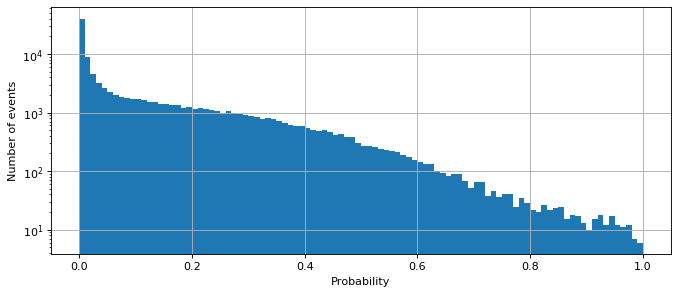

In [131]:
fig, ax = plt.subplots(figsize=(10,4))
flight_df_nonan[cls_proba_column].hist(
    ax=ax, bins=100, alpha=1, range=(0,1))
ax.set_ylabel('Number of events')
ax.set_xlabel('Probability')
ax.set_yscale('log')
fig.savefig(os.path.join(data_snippets_dir, cls_proba_column +'_distribution.svg'))
plt.show()

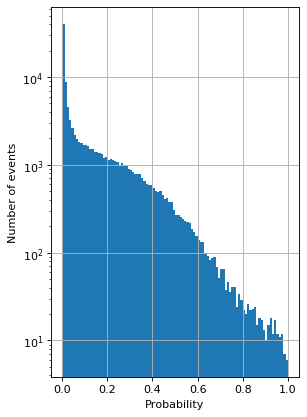

In [136]:
fig, ax = plt.subplots(figsize=(4,6))
flight_df_nonan[cls_proba_column].hist(
    ax=ax, bins=100, alpha=1, range=(0,1))
ax.set_ylabel('Number of events')
ax.set_xlabel('Probability')
ax.set_yscale('log')
fig.savefig(os.path.join(data_snippets_dir, cls_proba_column +'_distribution.svg'))
plt.show()

#### Events classified "air shower" - fraction of all events

In [137]:
np.count_nonzero(flight_df_nonan[cls_column])/num_all_events

0.016119233895132624

#### Events classified "air shower" - fraction of all events in gtu [36, 60]

In [138]:
np.count_nonzero(flight_df_nonan.query('gtu_in_packet >= 36 and gtu_in_packet <= 60')[cls_column])/num_gtu_36_60_events

0.024498030550485158

#### Packets classified "air shower" - fraction of all packets

In [139]:
num_cls_1_packets = \
    len(flight_df_nonan[flight_df_nonan[cls_column] == 1].groupby(
        ['source_file_acquisition', 'packet_id']).count()['event_id'])

In [140]:
print('num_cls_1_packets', num_cls_1_packets)

num_cls_1_packets 3918


In [141]:
num_cls_1_packets/num_all_packets

0.026900472371745577

#### Events classified "air shower" - fraction of all packets triggered in gtu [36, 60]

In [142]:
num_cls_1_gtu_36_60_packets = \
    len(flight_df_nonan[flight_df_nonan[cls_column] == 1] \
            .query('gtu_in_packet >= 36 and gtu_in_packet <= 60') \
            .groupby(['source_file_acquisition', 'packet_id']) \
            .count()['event_id'])

In [143]:
print('num_cls_1_gtu_36_60_packets', num_cls_1_gtu_36_60_packets)

num_cls_1_gtu_36_60_packets 3825


In [144]:
num_cls_1_gtu_36_60_packets/num_gtu_36_60_packets

0.027845926486754075

### Distribution of classified events by date

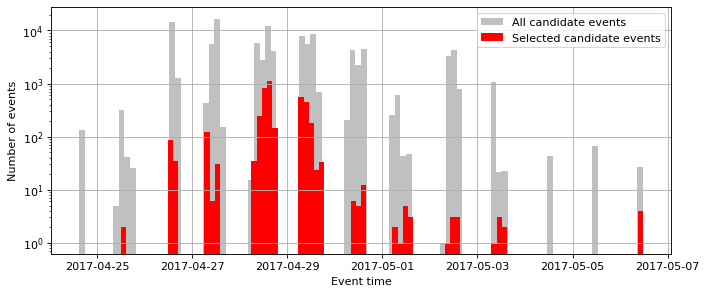

In [145]:
fig, ax = plt.subplots(figsize=(10,4))
flight_df_nonan['gps_datetime_min'].hist(ax=ax, bins=100, color='silver', label='All candidate events')
flight_df_nonan['gps_datetime_min'][flight_df_nonan[cls_column] == 1].hist(ax=ax, bins=100, color='red', label='Selected candidate events')
ax.set_yscale('log')
ax.set_ylabel('Number of events')
ax.set_xlabel('Event time')
ax.legend()
fig.savefig(os.path.join(data_snippets_dir, 'Distribution of classified events by date - log.svg'))
plt.show()

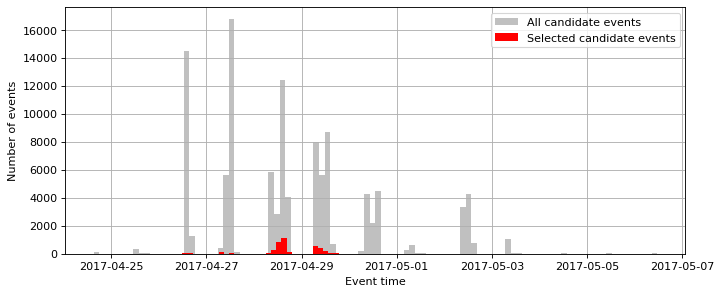

In [146]:
fig, ax = plt.subplots(figsize=(10,4))
flight_df_nonan['gps_datetime_min'].hist(ax=ax, bins=100, color='silver', label='All candidate events')
flight_df_nonan['gps_datetime_min'][flight_df_nonan[cls_column] == 1].hist(ax=ax, bins=100, color='red', label='Selected candidate events')
# ax.set_yscale('log')
ax.set_ylabel('Number of events')
ax.set_xlabel('Event time')
ax.legend()
fig.savefig(os.path.join(data_snippets_dir, 'Distribution of classified events by date - linear.svg'))
plt.show()

In [147]:
# TODO 
# - trigger rate S
# - trigger rate by manual classification

### Trigger rate

#### All flight HW events

In [148]:
# hw_trigger_num_per_file = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_num_per_file.pkl')
hw_trigger_rate_per_file = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_rate_per_file.pkl')
hw_file_trigger_datetimes = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_datetimes.pkl')
# hw_file_trigger_p_r = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_p_r.pkl')
# hw_file_trigger_timedelta = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_timedelta.pkl')
# hw_file_indices = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_indices.pkl')

#### All bgf=0.5 events

In [149]:
# bgf05_trigger_num_per_file_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_num_per_file.pkl')
bgf05_trigger_rate_per_file_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_rate_per_file.pkl')
bgf05_file_trigger_datetimes_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_datetimes.pkl')
# bgf05_file_trigger_p_r_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_p_r.pkl')
# bgf05_file_trigger_timedelta_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_timedelta.pkl')
# bgf05_file_indices_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_indices.pkl')

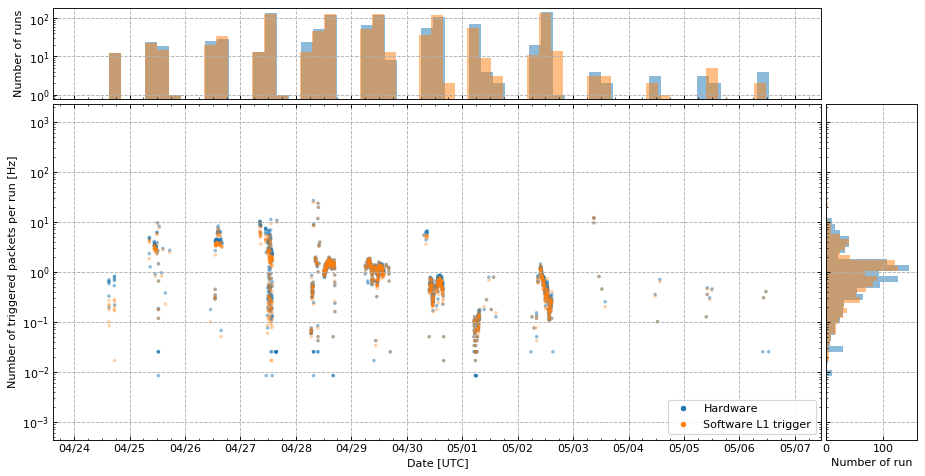

In [150]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        hw_file_trigger_datetimes,
        hw_trigger_rate_per_file, 
        ylim=(10**(-2.5), 10**(2.5)),
        label='Hardware', color='C0', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )
# gray

vis_trigger_rate_w_distributions(
    bgf05_file_trigger_datetimes_list,
    bgf05_trigger_rate_per_file_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Software L1 trigger', color='C1', hist_alpha=.5, scatter_alpha=.35,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_hw_vs_bgf05.png'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);
# dodgerblue

#### All classified events

In [151]:
all_classified_trigger_datetime_list, all_classified_trigger_rate_list = \
    count_trigger_rate_per_file_from_df(flight_df_nonan,  one_trg_per='packet')

1/987 allpackets-SPBEUSO-ACQUISITION-20170424-150143-001.001--CHECK.root
2/987 allpackets-SPBEUSO-ACQUISITION-20170424-150228-001.001--LONG.root
3/987 allpackets-SPBEUSO-ACQUISITION-20170424-150228-002.001--LONG.root
4/987 allpackets-SPBEUSO-ACQUISITION-20170424-150228-003.001--LONG.root
5/987 allpackets-SPBEUSO-ACQUISITION-20170424-150228-004.001--LONG.root
6/987 allpackets-SPBEUSO-ACQUISITION-20170424-150228-005.001--LONG.root
7/987 allpackets-SPBEUSO-ACQUISITION-20170424-172343-001.001--CHECK.root
8/987 allpackets-SPBEUSO-ACQUISITION-20170424-172427-001.001--LONG.root
9/987 allpackets-SPBEUSO-ACQUISITION-20170424-172427-002.001--LONG.root
10/987 allpackets-SPBEUSO-ACQUISITION-20170424-172427-003.001--LONG.root
11/987 allpackets-SPBEUSO-ACQUISITION-20170424-172427-004.001--LONG.root
12/987 allpackets-SPBEUSO-ACQUISITION-20170424-172427-005.001--LONG.root
13/987 allpackets-SPBEUSO-ACQUISITION-20170425-104043-001.001--CHECK.root
14/987 allpackets-SPBEUSO-ACQUISITION-20170425-104127-002

122/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-006.001--LONG-sqz.root
123/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-007.001--LONG-sqz-dis.root
124/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-007.001--LONG-sqz.root
125/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-008.001--LONG-sqz-dis.root
126/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-008.001--LONG-sqz.root
127/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-009.001--LONG-sqz-dis.root
128/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-009.001--LONG-sqz.root
129/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-010.001--LONG-sqz-dis.root
130/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-010.001--LONG-sqz.root
131/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-011.001--LONG-sqz-dis.root
132/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-011.001--LONG-sqz.root
133/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-012.001--LONG-sqz-dis.root
134/987 allpackets-SPBEUSO-ACQUISITION-2

240/987 allpackets-SPBEUSO-ACQUISITION-20170428-081726-009.001--LONG.root
241/987 allpackets-SPBEUSO-ACQUISITION-20170428-081726-011.001--LONG.root
242/987 allpackets-SPBEUSO-ACQUISITION-20170428-081726-012.001--LONG.root
243/987 allpackets-SPBEUSO-ACQUISITION-20170428-081726-016.001--LONG.root
244/987 allpackets-SPBEUSO-ACQUISITION-20170428-081726-017.001--LONG.root
245/987 allpackets-SPBEUSO-ACQUISITION-20170428-081726-024.001--LONG.root
246/987 allpackets-SPBEUSO-ACQUISITION-20170428-081726-025.001--LONG.root
247/987 allpackets-SPBEUSO-ACQUISITION-20170428-081726-026.001--LONG.root
248/987 allpackets-SPBEUSO-ACQUISITION-20170428-081726-030.001--LONG.root
249/987 allpackets-SPBEUSO-ACQUISITION-20170428-091746-001.001--CHECK.root
250/987 allpackets-SPBEUSO-ACQUISITION-20170428-092834-001.001--LONG.root
251/987 allpackets-SPBEUSO-ACQUISITION-20170428-092901-001.001--LONG.root
252/987 allpackets-SPBEUSO-ACQUISITION-20170428-093404-001.001--LONG.root
253/987 allpackets-SPBEUSO-ACQUISITIO

358/987 allpackets-SPBEUSO-ACQUISITION-20170428-151019-013.001--LONG.root
359/987 allpackets-SPBEUSO-ACQUISITION-20170428-151019-014.001--LONG.root
360/987 allpackets-SPBEUSO-ACQUISITION-20170428-151019-016.001--LONG.root
361/987 allpackets-SPBEUSO-ACQUISITION-20170428-151019-019.001--LONG.root
362/987 allpackets-SPBEUSO-ACQUISITION-20170428-151019-022.001--LONG.root
363/987 allpackets-SPBEUSO-ACQUISITION-20170428-151019-023.001--LONG.root
364/987 allpackets-SPBEUSO-ACQUISITION-20170428-151019-024.001--LONG.root
365/987 allpackets-SPBEUSO-ACQUISITION-20170428-151019-026.001--LONG.root
366/987 allpackets-SPBEUSO-ACQUISITION-20170428-151019-027.001--LONG.root
367/987 allpackets-SPBEUSO-ACQUISITION-20170428-160759-001.001--CHECK.root
368/987 allpackets-SPBEUSO-ACQUISITION-20170428-161317-001.001--LONG.root
369/987 allpackets-SPBEUSO-ACQUISITION-20170428-161317-002.001--LONG.root
370/987 allpackets-SPBEUSO-ACQUISITION-20170428-161317-003.001--LONG.root
371/987 allpackets-SPBEUSO-ACQUISITIO

483/987 allpackets-SPBEUSO-ACQUISITION-20170429-110448-003.001--LONG.root
484/987 allpackets-SPBEUSO-ACQUISITION-20170429-110448-004.001--LONG-sqz.root
485/987 allpackets-SPBEUSO-ACQUISITION-20170429-110448-004.001--LONG.root
486/987 allpackets-SPBEUSO-ACQUISITION-20170429-110448-005.001--LONG-sqz.root
487/987 allpackets-SPBEUSO-ACQUISITION-20170429-110448-005.001--LONG.root
488/987 allpackets-SPBEUSO-ACQUISITION-20170429-110448-006.001--LONG-sqz.root
489/987 allpackets-SPBEUSO-ACQUISITION-20170429-110448-007.001--LONG-sqz.root
490/987 allpackets-SPBEUSO-ACQUISITION-20170429-110448-008.001--LONG-sqz.root
491/987 allpackets-SPBEUSO-ACQUISITION-20170429-110448-009.001--LONG-sqz.root
492/987 allpackets-SPBEUSO-ACQUISITION-20170429-110448-010.001--LONG-sqz.root
493/987 allpackets-SPBEUSO-ACQUISITION-20170429-110448-010.001--LONG.root
494/987 allpackets-SPBEUSO-ACQUISITION-20170429-110448-011.001--LONG-sqz.root
495/987 allpackets-SPBEUSO-ACQUISITION-20170429-110448-012.001--LONG-sqz.root
49

599/987 allpackets-SPBEUSO-ACQUISITION-20170430-095101-006.001--LONG-sqz.root
600/987 allpackets-SPBEUSO-ACQUISITION-20170430-095101-007.001--LONG-sqz.root
601/987 allpackets-SPBEUSO-ACQUISITION-20170430-095101-008.001--LONG-sqz.root
602/987 allpackets-SPBEUSO-ACQUISITION-20170430-095101-009.001--LONG-sqz.root
603/987 allpackets-SPBEUSO-ACQUISITION-20170430-095101-010.001--LONG-sqz.root
604/987 allpackets-SPBEUSO-ACQUISITION-20170430-095101-011.001--LONG-sqz.root
605/987 allpackets-SPBEUSO-ACQUISITION-20170430-095101-012.001--LONG-sqz.root
606/987 allpackets-SPBEUSO-ACQUISITION-20170430-095101-013.001--LONG-sqz.root
607/987 allpackets-SPBEUSO-ACQUISITION-20170430-095101-014.001--LONG-sqz.root
608/987 allpackets-SPBEUSO-ACQUISITION-20170430-095101-015.001--LONG-sqz.root
609/987 allpackets-SPBEUSO-ACQUISITION-20170430-095101-016.001--LONG-sqz.root
610/987 allpackets-SPBEUSO-ACQUISITION-20170430-095101-017.001--LONG-sqz.root
611/987 allpackets-SPBEUSO-ACQUISITION-20170430-095101-018.001--

706/987 allpackets-SPBEUSO-ACQUISITION-20170430-143623-001.001--CHECK.root
707/987 allpackets-SPBEUSO-ACQUISITION-20170430-143708-001.001--LONG-sqz.root
708/987 allpackets-SPBEUSO-ACQUISITION-20170430-143708-002.001--LONG-sqz.root
709/987 allpackets-SPBEUSO-ACQUISITION-20170430-143708-003.001--LONG-sqz.root
710/987 allpackets-SPBEUSO-ACQUISITION-20170430-143708-004.001--LONG-sqz.root
711/987 allpackets-SPBEUSO-ACQUISITION-20170430-143708-005.001--LONG-sqz.root
712/987 allpackets-SPBEUSO-ACQUISITION-20170430-143708-006.001--LONG-sqz.root
713/987 allpackets-SPBEUSO-ACQUISITION-20170430-143708-007.001--LONG-sqz.root
714/987 allpackets-SPBEUSO-ACQUISITION-20170430-143708-008.001--LONG-sqz.root
715/987 allpackets-SPBEUSO-ACQUISITION-20170430-143708-009.001--LONG-sqz.root
716/987 allpackets-SPBEUSO-ACQUISITION-20170430-143708-010.001--LONG-sqz.root
717/987 allpackets-SPBEUSO-ACQUISITION-20170430-143708-011.001--LONG-sqz.root
718/987 allpackets-SPBEUSO-ACQUISITION-20170430-143708-012.001--LON

829/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-011.001--LONG-sqz.root
830/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-012.001--LONG-sqz.root
831/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-013.001--LONG-sqz.root
832/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-014.001--LONG-sqz.root
833/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-015.001--LONG-sqz.root
834/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-016.001--LONG-sqz.root
835/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-017.001--LONG-sqz.root
836/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-018.001--LONG-sqz.root
837/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-019.001--LONG-sqz.root
838/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-020.001--LONG-sqz.root
839/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-021.001--LONG-sqz.root
840/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-022.001--LONG-sqz.root
841/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-023.001--

975/987 allpackets-SPBEUSO-ACQUISITION-20170503-090032-001.001--CHECK.root
976/987 allpackets-SPBEUSO-ACQUISITION-20170503-111308-001.001--CHECK.root
977/987 allpackets-SPBEUSO-ACQUISITION-20170503-122552-001.001--CHECK.root
978/987 allpackets-SPBEUSO-ACQUISITION-20170503-135121-001.001--CHECK.root
979/987 allpackets-SPBEUSO-ACQUISITION-20170504-113024-001.001--CHECK.root
980/987 allpackets-SPBEUSO-ACQUISITION-20170504-123121-001.001--CHECK.root
981/987 allpackets-SPBEUSO-ACQUISITION-20170504-133219-001.001--CHECK.root
982/987 allpackets-SPBEUSO-ACQUISITION-20170505-100211-001.001--CHECK.root
983/987 allpackets-SPBEUSO-ACQUISITION-20170505-100435-001.001--CHECK.root
984/987 allpackets-SPBEUSO-ACQUISITION-20170505-110545-001.001--CHECK.root
985/987 allpackets-SPBEUSO-ACQUISITION-20170505-120644-001.001--CHECK.root
986/987 allpackets-SPBEUSO-ACQUISITION-20170506-102615-001.001--CHECK.root
987/987 allpackets-SPBEUSO-ACQUISITION-20170506-112714-001.001--CHECK.root


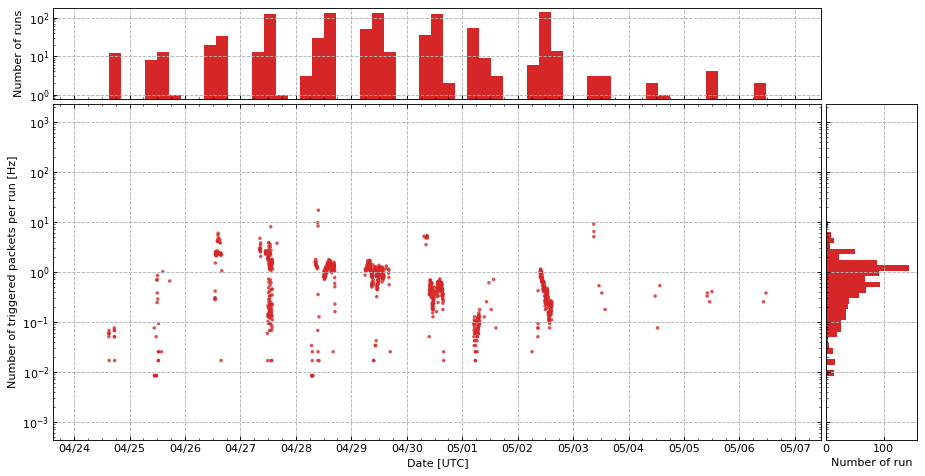

In [152]:
vis_trigger_rate_w_distributions(
    all_classified_trigger_datetime_list, 
    all_classified_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)),
    color='C3',
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_classified_all.png')
);
# limegreen

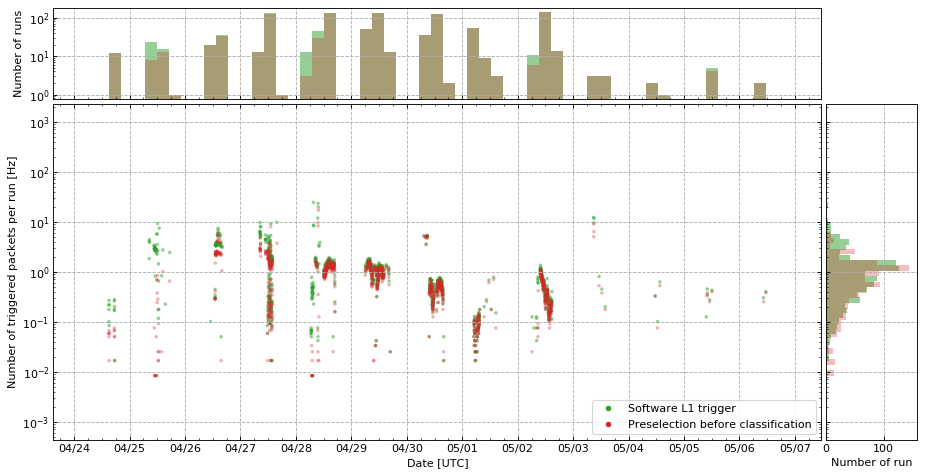

In [153]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        bgf05_file_trigger_datetimes_list,
        bgf05_trigger_rate_per_file_list,
        ylim=(10**(-2.5), 10**(2.5)),
        label='Software L1 trigger', color='C2', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )
#dodgerblue

vis_trigger_rate_w_distributions(
    all_classified_trigger_datetime_list, 
    all_classified_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Preselection before classification', color='C3', hist_alpha=.3, scatter_alpha=.35,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_bgf05_vs_classified.png'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);

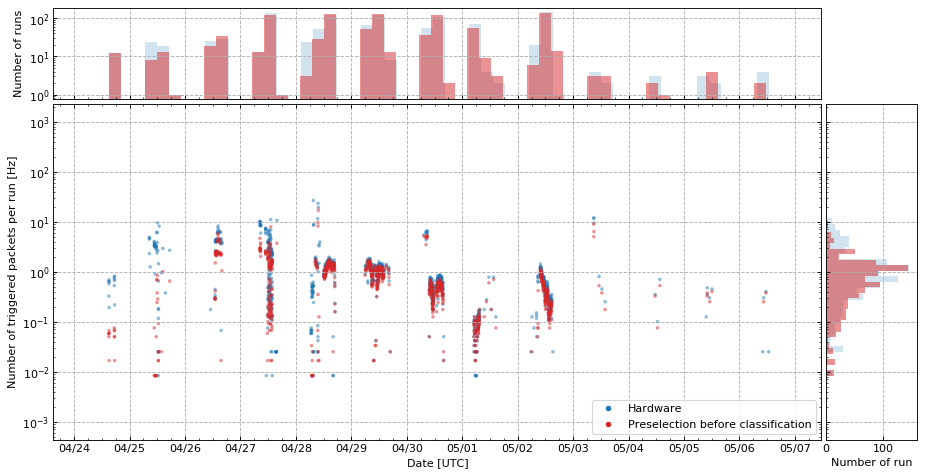

In [154]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        hw_file_trigger_datetimes,
        hw_trigger_rate_per_file, 
        ylim=(10**(-2.5), 10**(2.5)),
        label='Hardware', color='C0', hist_alpha=.2, scatter_alpha=.5,
        show=False
    )

vis_trigger_rate_w_distributions(
    all_classified_trigger_datetime_list, 
    all_classified_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Preselection before classification', color='C3', hist_alpha=.5, scatter_alpha=.5,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_hw_vs_classified.png'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);

#### Events classified as "air shower"

In [155]:
shower_trigger_datetime_list, shower_trigger_rate_list = \
    count_trigger_rate_per_file_from_df(flight_df_nonan[flight_df_nonan[cls_column] == 1],  one_trg_per='packet')

1/342 allpackets-SPBEUSO-ACQUISITION-20170425-115921-004.001--LONG.root
2/342 allpackets-SPBEUSO-ACQUISITION-20170426-125930-002.001--LONG.root
3/342 allpackets-SPBEUSO-ACQUISITION-20170426-125930-003.001--LONG.root
4/342 allpackets-SPBEUSO-ACQUISITION-20170426-125930-005.001--LONG.root
5/342 allpackets-SPBEUSO-ACQUISITION-20170426-125930-006.001--LONG.root
6/342 allpackets-SPBEUSO-ACQUISITION-20170426-125930-007.001--LONG.root
7/342 allpackets-SPBEUSO-ACQUISITION-20170426-125930-008.001--LONG.root
8/342 allpackets-SPBEUSO-ACQUISITION-20170426-125930-009.001--LONG.root
9/342 allpackets-SPBEUSO-ACQUISITION-20170426-125930-010.001--LONG.root
10/342 allpackets-SPBEUSO-ACQUISITION-20170426-125930-011.001--LONG.root
11/342 allpackets-SPBEUSO-ACQUISITION-20170426-125930-013.001--LONG.root
12/342 allpackets-SPBEUSO-ACQUISITION-20170426-125930-014.001--LONG.root
13/342 allpackets-SPBEUSO-ACQUISITION-20170426-125930-015.001--LONG.root
14/342 allpackets-SPBEUSO-ACQUISITION-20170426-125930-016.00

155/342 allpackets-SPBEUSO-ACQUISITION-20170428-140915-013.001--LONG.root
156/342 allpackets-SPBEUSO-ACQUISITION-20170428-140915-014.001--LONG.root
157/342 allpackets-SPBEUSO-ACQUISITION-20170428-140915-015.001--LONG.root
158/342 allpackets-SPBEUSO-ACQUISITION-20170428-140915-016.001--LONG.root
159/342 allpackets-SPBEUSO-ACQUISITION-20170428-140915-017.001--LONG.root
160/342 allpackets-SPBEUSO-ACQUISITION-20170428-140915-018.001--LONG.root
161/342 allpackets-SPBEUSO-ACQUISITION-20170428-140915-019.001--LONG.root
162/342 allpackets-SPBEUSO-ACQUISITION-20170428-140915-020.001--LONG.root
163/342 allpackets-SPBEUSO-ACQUISITION-20170428-140915-021.001--LONG.root
164/342 allpackets-SPBEUSO-ACQUISITION-20170428-140915-022.001--LONG.root
165/342 allpackets-SPBEUSO-ACQUISITION-20170428-140915-023.001--LONG.root
166/342 allpackets-SPBEUSO-ACQUISITION-20170428-140915-024.001--LONG.root
167/342 allpackets-SPBEUSO-ACQUISITION-20170428-140915-025.001--LONG.root
168/342 allpackets-SPBEUSO-ACQUISITION

311/342 allpackets-SPBEUSO-ACQUISITION-20170429-161009-007.001--LONG.root
312/342 allpackets-SPBEUSO-ACQUISITION-20170430-095015-001.001--CHECK.root
313/342 allpackets-SPBEUSO-ACQUISITION-20170430-095101-011.001--LONG-sqz.root
314/342 allpackets-SPBEUSO-ACQUISITION-20170430-095101-013.001--LONG-sqz.root
315/342 allpackets-SPBEUSO-ACQUISITION-20170430-105121-001.001--CHECK.root
316/342 allpackets-SPBEUSO-ACQUISITION-20170430-115225-001.001--CHECK.root
317/342 allpackets-SPBEUSO-ACQUISITION-20170430-125414-014.001--LONG-sqz.root
318/342 allpackets-SPBEUSO-ACQUISITION-20170430-125414-016.001--LONG-sqz.root
319/342 allpackets-SPBEUSO-ACQUISITION-20170430-133518-001.001--CHECK.root
320/342 allpackets-SPBEUSO-ACQUISITION-20170430-143623-001.001--CHECK.root
321/342 allpackets-SPBEUSO-ACQUISITION-20170430-143708-002.001--LONG-sqz.root
322/342 allpackets-SPBEUSO-ACQUISITION-20170430-153728-001.001--CHECK.root
323/342 allpackets-SPBEUSO-ACQUISITION-20170430-153812-004.001--LONG-sqz.root
324/342 

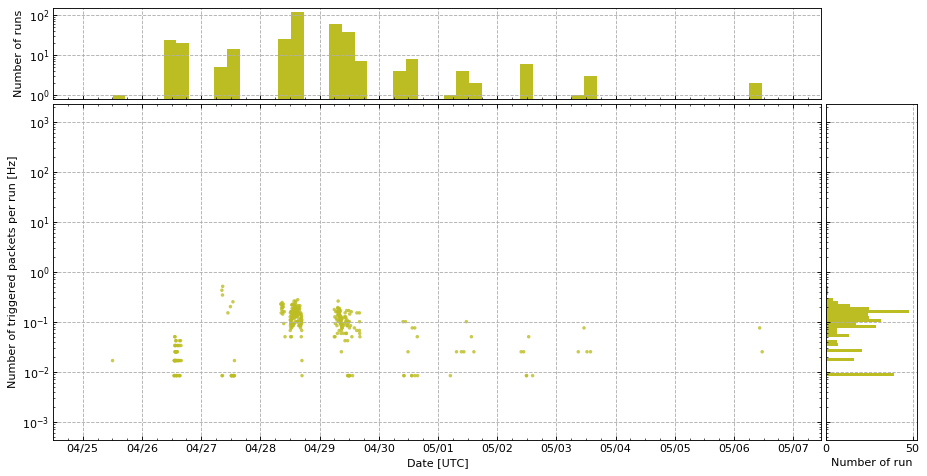

In [156]:
vis_trigger_rate_w_distributions(
    shower_trigger_datetime_list, 
    shower_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)),
    color='C8',
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_classified_air_shower.png')
);

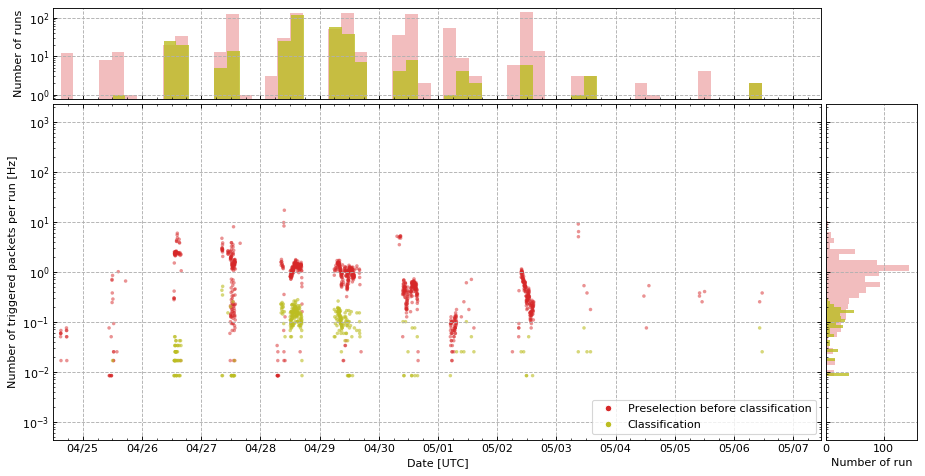

In [157]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        all_classified_trigger_datetime_list, 
        all_classified_trigger_rate_list,
        ylim=(10**(-2.5), 10**(2.5)),
        label='Preselection before classification', color='C3', hist_alpha=.3, scatter_alpha=.5,
        show=False
    )

vis_trigger_rate_w_distributions(
    shower_trigger_datetime_list, 
    shower_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Classification', color='C8', hist_alpha=.8, scatter_alpha=.6,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_classified_vs_selected.png'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);

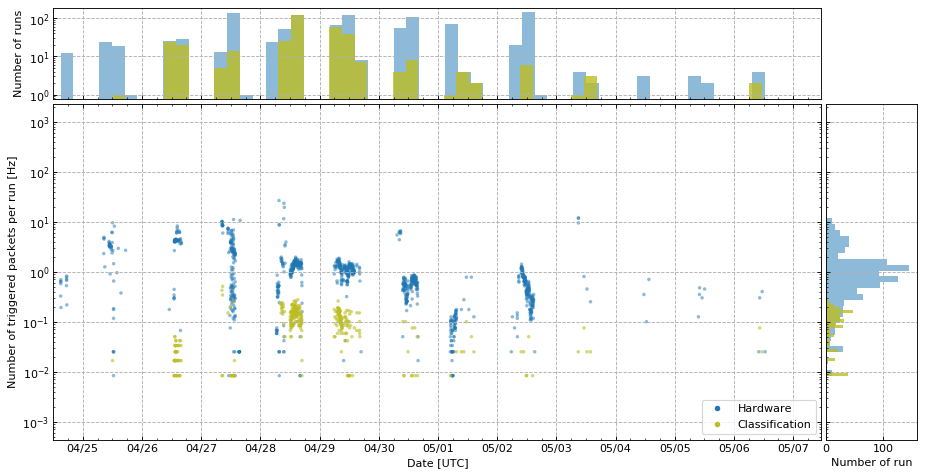

In [158]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        hw_file_trigger_datetimes,
        hw_trigger_rate_per_file, 
        ylim=(10**(-2.5), 10**(2.5)),
        label='Hardware', color='C0', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )

vis_trigger_rate_w_distributions(
    shower_trigger_datetime_list, 
    shower_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Classification', color='C8', hist_alpha=.8, scatter_alpha=.6,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_hw_vs_selected.png'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);

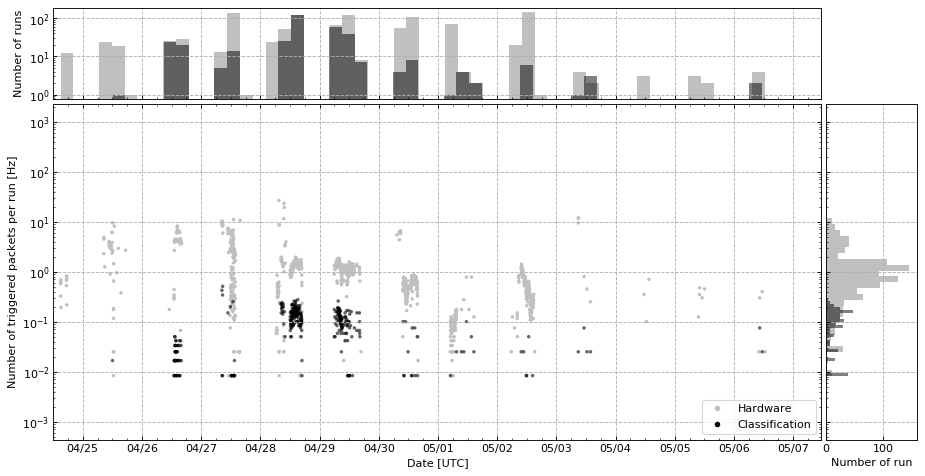

In [159]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        hw_file_trigger_datetimes,
        hw_trigger_rate_per_file, 
        ylim=(10**(-2.5), 10**(2.5)),
        label='Hardware', color='silver', hist_alpha=1, scatter_alpha=1,
        show=False
    )

vis_trigger_rate_w_distributions(
    shower_trigger_datetime_list, 
    shower_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Classification', color='black', hist_alpha=.5, scatter_alpha=.6,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_hw_vs_selected_bw.png'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);

#### Summary - mean trigger rate

In [160]:
print('Mean trigger rate in hardware data:          ', np.mean(hw_trigger_rate_per_file))
print('Mean trigger rate in feature-extracted data: ', np.mean(bgf05_trigger_rate_per_file_list))
print('Mean trigger rate in classified data:        ', np.mean(all_classified_trigger_rate_list))
print('Mean trigger rate in classifer selected data:', np.mean(shower_trigger_rate_list))

Mean trigger rate in hardware data:           1.448051447935921
Mean trigger rate in feature-extracted data:  1.3001118568232661
Mean trigger rate in classified data:         0.9263860716700473
Mean trigger rate in classifer selected data: 0.10360623781676415


### Distribution of classified events by manual classification

In [161]:
sns.set(style="whitegrid")

In [162]:
flight_df_nonan[manual_classification_class_name_column].value_counts()

unclassified              107444
pixel                        365
top_left_ec                  295
blob                         270
bg_increased_suddenly        193
large_blob                   130
dot_w_blob_behind            123
few_dots                      84
bright_blob                   77
noise                         65
short_single_gtu_track        53
single_gtu_track              51
persistent_dot                29
2pix_line                     22
unspecified                   22
noise_unspecified             21
cartesian_line                15
blob_and_dots                 15
sparse_blobs                  12
noise_with_week_dot           12
storng_light                   3
Name: manual_classification_class_name, dtype: int64

Withount unclassified
All flight data in the selection


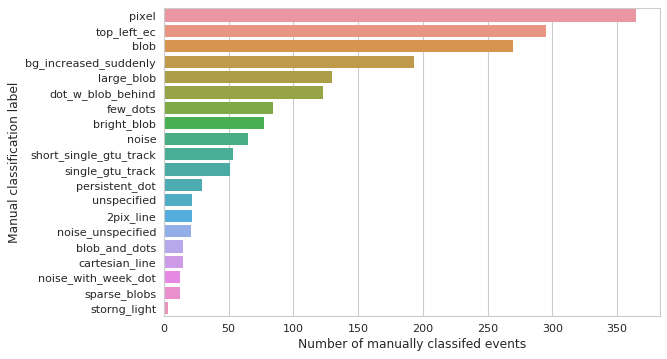

Events classified as positive


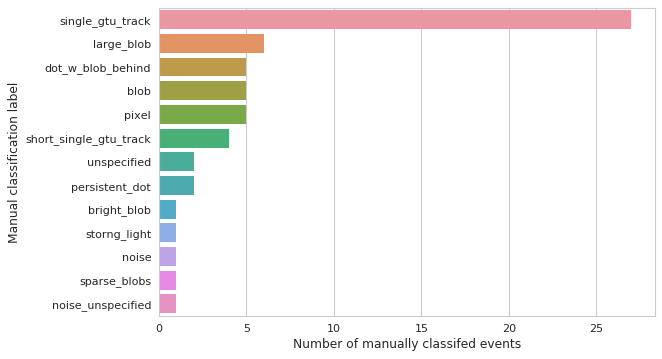

With unclassified
All flight data in the selection


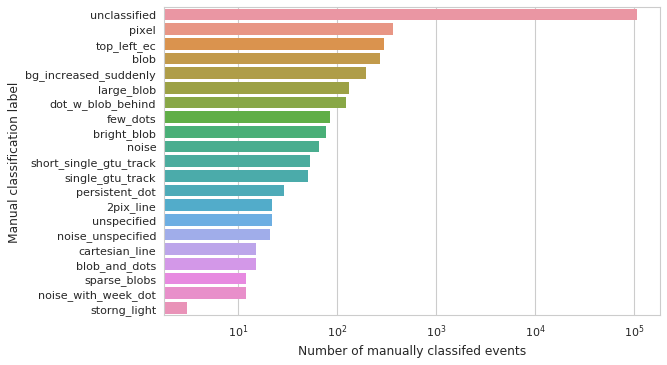

Events classified as positive


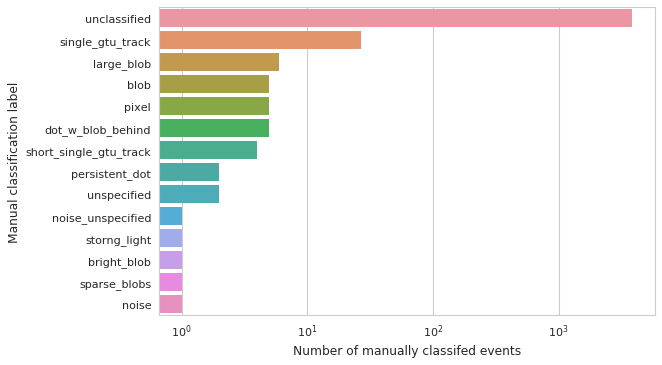

In [167]:
# requires manual_classification_class_name_column

for w_unclassified in [False, True]:
    
    print('{} unclassified'.format('With' if w_unclassified else 'Withount'))
    
    for apply_air_shower_filter in [False, True]:
    
        print('Events classified as positive' if apply_air_shower_filter else 'All flight data in the selection')
    
        subset_df = \
            flight_df_nonan[flight_df_nonan[manual_classification_class_number_column] != EVENT_CLASSES['unclassified']] \
            if not w_unclassified else \
            flight_df_nonan
    
        subset_df = subset_df[subset_df[cls_column] == 1] \
            if apply_air_shower_filter else subset_df
    
        fig, ax = plt.subplots(1, figsize=(8,5))
        sns.countplot(y=manual_classification_class_name_column, 
                      data=subset_df, ax=ax, orient='v',
                      order=subset_df[manual_classification_class_name_column].value_counts().index,
                     )
        
        ax.set_ylabel('Manual classification label')
        ax.set_xlabel('Number of manually classifed events')

        flight_data_manual_classification_class_name_dist_fig_pathname = \
            os.path.join(
                data_snippets_dir, 
                'flight_data_manual_classification_class_name_distribution{}{}.svg'.format(
                    '_with_unclassified' if w_unclassified else '',
                    '_positive' if apply_air_shower_filter else ''
                ))

        if w_unclassified:
            ax.set_xscale('log')

        fig.savefig(flight_data_manual_classification_class_name_dist_fig_pathname, dpi=150)
        plt.show()
    
    print('='*50)

In [164]:
w_unclassified = False
apply_air_shower_filter = True

subset_df = \
    flight_df_nonan[
        flight_df_nonan[manual_classification_class_number_column] != EVENT_CLASSES['unclassified']
    ] if not w_unclassified else flight_df_nonan

print('All flight data in the selection')
print(subset_df.groupby([manual_classification_class_name_column])['event_id'].count())
print('-'*50)
print('Events classified as positive')
print(subset_df[subset_df[cls_column] == 1].groupby([manual_classification_class_name_column])['event_id'].count())
print('-'*50)
print('Ratios')

flight_data_nonan_class_ratios_df = \
    subset_df.groupby([manual_classification_class_name_column])[cls_column] \
        .value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values(cls_column)

flight_data_nonan_class_ratios_df #[flight_data_nonan_class_ratios_df[cls_column] == 1]

All flight data in the selection
manual_classification_class_name
2pix_line                  22
bg_increased_suddenly     193
blob                      270
blob_and_dots              15
bright_blob                77
cartesian_line             15
dot_w_blob_behind         123
few_dots                   84
large_blob                130
noise                      65
noise_unspecified          21
noise_with_week_dot        12
persistent_dot             29
pixel                     365
short_single_gtu_track     53
single_gtu_track           51
sparse_blobs               12
storng_light                3
top_left_ec               295
unspecified                22
Name: event_id, dtype: int64
--------------------------------------------------
Events classified as positive
manual_classification_class_name
blob                       5
bright_blob                1
dot_w_blob_behind          5
large_blob                 6
noise                      1
noise_unspecified          1
persistent_dot   

,manual_classification_class_name,extra_trees_cls_on_train_rfecv_est_dropna,percentage
0,2pix_line,0,100.000000
20,pixel,0,98.630137
25,single_gtu_track,0,47.058824
18,persistent_dot,0,93.103448
17,noise_with_week_dot,0,100.000000
31,unspecified,0,90.909091
15,noise_unspecified,0,95.238095
26,sparse_blobs,0,91.666667
13,noise,0,98.461538
10,few_dots,0,100.000000


Withount unclassified


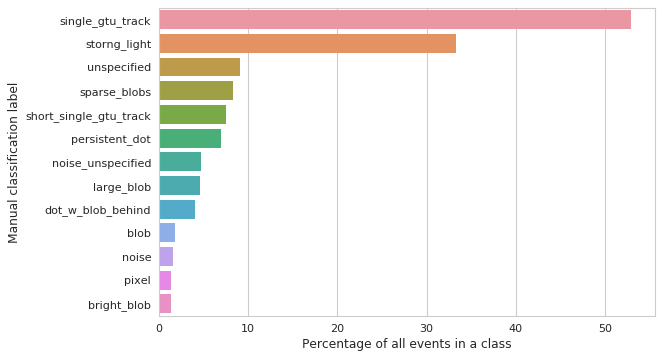

With unclassified


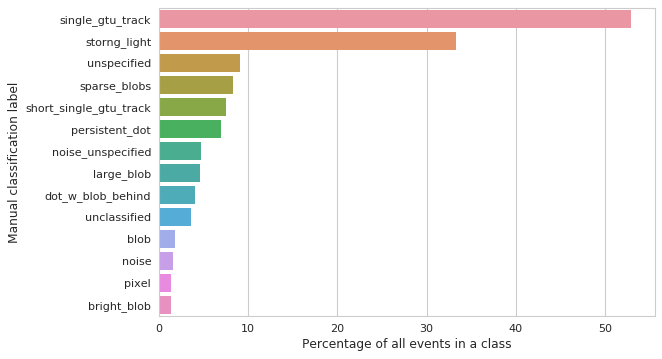

In [170]:
# flight_data_nonan_class_ratios_df

for w_unclassified in [False, True]:
    
    print('{} unclassified'.format('With' if w_unclassified else 'Withount'))

    subset_df = \
        flight_df_nonan[
            flight_df_nonan[manual_classification_class_number_column] != EVENT_CLASSES['unclassified']
        ] if not w_unclassified else flight_df_nonan

    flight_data_nonan_class_ratios_df = \
        subset_df.groupby([manual_classification_class_name_column])[cls_column] \
            .value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values(cls_column)

    fig, ax = plt.subplots(1, figsize=(8,5))

    subset_df = flight_data_nonan_class_ratios_df[flight_data_nonan_class_ratios_df[cls_column] == 1]
    
    p = sns.barplot(y=manual_classification_class_name_column, 
                    x="percentage", #hue=cls_column, 
                    data=subset_df, 
                    ax=ax, orient='h',
                    order=subset_df[manual_classification_class_name_column].iloc[
                        np.argsort(-subset_df["percentage"])]
                   )

    ax.set_ylabel('Manual classification label')
    ax.set_xlabel('Percentage of all events in a class')

    flight_data_manual_classification_class_name_dist_fig_pathname = \
        os.path.join(
            data_snippets_dir, 
            'flight_data_manual_classification_class_name_normalized_distribution{}.svg'.format(
                '_with_unclassified' if w_unclassified else ''
            ))

#     if w_unclassified:
#         ax.set_xscale('log')

    fig.savefig(flight_data_manual_classification_class_name_dist_fig_pathname, dpi=150)
    plt.show()

In [75]:
mpl.rcParams.update(mpl.rcParamsDefault)

### Saving flight data into tsv
(not in the report)

In [76]:
save_flight_data_dump_file = True
overwrite_flight_data_dump_file = False

In [77]:
if save_flight_data_dump_file:
    flight_data_tsv_pathname = os.path.join(data_snippets_dir, 'flight_data.tsv.gz')

    if overwrite_flight_data_dump_file or not os.path.exists(flight_data_tsv_pathname):
        print('Saving', flight_data_tsv_pathname)
        flight_df.to_csv(flight_data_tsv_pathname, sep='\t', compression='gzip')
    else:
        print('Already exists', flight_data_tsv_pathname)

Saving ver4_machine_learning_flight_classification_tsne_cfg3_201906122_2/flight_data.tsv.gz


# Visualization of the events

## Visualizing the features

In [78]:
flight_df_nonan[rfecv_selector_on_extra_trees__column_names + ['manual_classification_class_number']].head()

,num_gtu,trg_box_per_gtu_max,trg_box_per_gtu_sum,trg_box_per_gtu_mean,trg_pmt_per_gtu_max,trg_pmt_per_gtu_sum,trg_pmt_per_gtu_mean,trg_ec_per_gtu_sum,trg_ec_per_gtu_mean,trg_x_y_clusters_sizes_min,...,alt1_x_y_hough_peak_thr1_line_clusters_max_size_clu_height,alt1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,alt1_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width,alt1_x_y_hough_peak_thr1_line_clusters_max_area_clu_size,alt1_x_y_hough_peak_thr1_line_clusters_max_peak_clu_size,alt1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_size,alt1_gtu_x_hough_peak_thr1_major_line_rho,alt1_gtu_x_hough_peak_thr2_major_line_rho,alt1_gtu_x_hough_peak_thr3_major_line_rho,manual_classification_class_number
0,11,7.0,9.0,0.818182,1.0,3.0,0.272727,3.0,0.272727,1,...,3,8,8,8,8,8,4.74049,4.60184,5.41446,-1.0
1,11,7.0,15.0,1.363640,2.0,4.0,0.363636,3.0,0.272727,7,...,15,33,5,25,6,25,2.31214,1.70155,2.29509,-1.0
2,9,1.0,1.0,0.111111,1.0,1.0,0.111111,1.0,0.111111,1,...,10,26,26,48,48,48,3.52568,3.15889,1.96062,-1.0
3,9,1.0,1.0,0.111111,1.0,1.0,0.111111,1.0,0.111111,1,...,42,78,78,84,84,84,4.01495,2.76942,3.05407,-1.0
4,22,7.0,22.0,1.000000,2.0,10.0,0.454545,10.0,0.454545,16,...,54,112,112,100,100,100,2.44340,5.69936,5.69849,-1.0


### Features used by the model

In [79]:
len(rfecv_selector_on_extra_trees__column_names)

196

In [80]:
importances = extra_trees_cls_on_train_rfecv_est.feature_importances_
indices = np.argsort(importances)[::-1]


rfecv_selector_on_extra_trees__column_names_indices_importances__sorted = \
    sorted(
        [
            (rfecv_selector_on_extra_trees__column_names[indices[f]], indices[f], importances[indices[f]]) \
            for f in range(len(rfecv_selector_on_extra_trees__column_names)) 
        ], 
        key=lambda e: e[2],
        reverse=True
    )

for column_name, column_indice, column_importance in \
        rfecv_selector_on_extra_trees__column_names_indices_importances__sorted:
    print('{:<70}{:.4f}'.format(column_name,column_importance))


rfecv_selector_on_extra_trees__column_names__sorted = \
    [e[0] for e in rfecv_selector_on_extra_trees__column_names_indices_importances__sorted]

rfecv_selector_on_extra_trees__column_indices__sorted = \
    [e[1] for e in rfecv_selector_on_extra_trees__column_names_indices_importances__sorted]

proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_width            0.0352
proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width             0.0318
proc2_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width             0.0272
proc1_x_y_hough_peak_thr1_line_clusters_clu_widths_max                0.0255
proc3_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width             0.0246
proc2_x_y_hough_peak_thr1_line_clusters_count                         0.0238
proc2_x_y_hough_peak_thr1_line_clusters_max_area_clu_width            0.0215
proc3_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width            0.0208
alt1_x_y_hough_peak_thr1_line_clusters_clu_widths_max                 0.0203
proc1_x_y_hough_peak_thr1_line_clusters_max_area_clu_width            0.0191
proc2_x_y_hough_peak_thr1_line_clusters_clu_widths_max                0.0177
proc2_x_y_hough_peak_thr2_line_clusters_count                         0.0169
proc1_x_y_hough_peak_thr1_line_clusters_max_peak_clu_height           0.0168

### Radvis

Presently not applied optimally, any useful output is not guarateed

In [ ]:
plt.close('all')
sns.set(style="whitegrid")

In [81]:
# plt.close('all')
# for num_features in range(5,80,20):
#     print('Number of features:\t{}'.format(num_features))
#     f, ax = plt.subplots()
#     f.set_size_inches(20,20)
#     pd.plotting.radviz(
#         flight_df_nonan[rfecv_selector_on_extra_trees__column_names__sorted[0:num_features] + ['manual_classification_class_name']], 
#         'manual_classification_class_name', alpha=.8
#     )
#     plt.show()

In [82]:
mpl.rcParams.update(mpl.rcParamsDefault)

## T-SNE

In [ ]:
%load_ext wurlitzer
# from sklearn.manifold import TSNE
import MulticoreTSNE
from sklearn.externals import joblib

In [ ]:
load_existing_tsne_model = True
refit_tsne_model = False
dump_tsne_embedding = True
show_plots = True

### Fitting

In [ ]:
tsne_hyperparams_dict = dict(
    learning_rate=100,
    n_iter=5000,
    perplexity=50, 
    angle=0.3,
    verbose=10,
    random_state=9621
)

In [ ]:
num_columns_list = list(range(50, len(rfecv_selector_on_extra_trees__column_names)+1, 50))

if (len(rfecv_selector_on_extra_trees__column_names)-50) % 50 != 0:
    num_columns_list += [len(rfecv_selector_on_extra_trees__column_names)]

In [ ]:
num_columns_list

In [ ]:
rfecv_selector_on_extra_trees__column_names__sorted

In [ ]:
tsne_hyperparams_dict_md5str = hashlib.md5(';'.join(['{}={}'.format(k,v) for k,v in sorted(tsne_hyperparams_dict.items())]).encode()).hexdigest()

flight_rfecv_columns__X_tsne_dict = {}
tsne_on_flight_nonan_rfecv_columns_X_pathname_dict = {}

for num_columns in num_columns_list:
    
    tsne_on_flight_nonan_rfecv_columns_X_pathname_dict[num_columns] = \
        os.path.join(data_snippets_dir, 'tsne_flight_nonan__cfg_{}__{}_rfecv_columns__X.npy'.format(tsne_hyperparams_dict_md5str, num_columns))
    
    print('Fitting T-SNE of {} features'.format(num_columns))
    print('Pickled file pathname', tsne_on_flight_nonan_rfecv_columns_X_pathname_dict[num_columns])
    
    if refit_tsne_model or not os.path.exists(tsne_on_flight_nonan_rfecv_columns_X_pathname_dict[num_columns]):
        tsne_on_flight_nonan_rfecv_columns = MulticoreTSNE.MulticoreTSNE(**tsne_hyperparams_dict, n_jobs=10)
        flight_rfecv_columns__X_tsne_dict[num_columns] = tsne_on_flight_nonan_rfecv_columns.fit_transform(
            flight_rfecv_columns__X.T[rfecv_selector_on_extra_trees__column_indices__sorted[:num_columns+1]].T)
#         if dump_tsne_model: 
#             joblib.dump(tsne_on_flight_nonan_rfecv_columns, tsne_on_flight_nonan_rfecv_columns_pathname_dict[num_columns], compress=1)
        if dump_tsne_embedding:
            np.save(tsne_on_flight_nonan_rfecv_columns_X_pathname_dict[num_columns], flight_rfecv_columns__X_tsne_dict[num_columns])
        
    else:
#         tsne_on_flight_nonan_rfecv_columns = joblib.load(tsne_on_flight_nonan_rfecv_columns_pathname_dict[num_columns])
#         flight_rfecv_columns__X_tsne_dict[num_columns] = tsne_on_flight_nonan_rfecv_columns.embedding_
        flight_rfecv_columns__X_tsne_dict[num_columns] = np.load(tsne_on_flight_nonan_rfecv_columns_X_pathname_dict[num_columns])

In [ ]:
for num_columns, X_tsne in flight_rfecv_columns__X_tsne_dict.items():
    
    x_col_prefix = 'tsne_{}_feat__'.format(num_columns)
    
    flight_df[x_col_prefix + 'X_0'] = np.nan
    flight_df[x_col_prefix + 'X_1'] = np.nan

    flight_df.loc[flight_df['event_id'].isin(flight_df_nonan['event_id']), x_col_prefix + 'X_0'] = flight_rfecv_columns__X_tsne_dict[num_columns][:, 0]
    flight_df.loc[flight_df['event_id'].isin(flight_df_nonan['event_id']), x_col_prefix + 'X_1'] = flight_rfecv_columns__X_tsne_dict[num_columns][:, 1]

# flight_df_nonan = flight_df[~flight_df['had_nan_fields']]

### Updating `flight_df_nonan` with T-SNE dimension values
(not in the report)

In [ ]:
flight_df_nonan = flight_df[~flight_df['had_nan_fields']]

### Visualizing results of T-SNE

In [ ]:
EVENT_CLASSES

#### All classes in a single plot

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import data_analysis_utils

In [ ]:
def check_row_is_extra_trees_1(row, cls_column='extra_trees_cls_on_train_rfecv_est_dropna'):
    return r[cls_column] == 1

def add_tsne_shower_xy_axes(fig, scatter_plot_ax, df_nonan, annotation_side_frac, annotation_limit=None,
                            highlight_check_func=check_row_is_extra_trees_1, highlight_color='red', 
                            event_id_fontsize=8.5, event_id_color='red', cls_column='extra_trees_cls_on_train_rfecv_est_dropna', 
                            col_x0='tsne__X_0', col_x1='tsne__X_1', show_event_id=True):
        
    ax_lim_width = (scatter_plot_ax.get_xlim()[1]-scatter_plot_ax.get_xlim()[0])
    annotation_side = annotation_side_frac*ax_lim_width

    shown_images = np.array([[1., 1.]])  # just something big
    
    for _i, (i, r) in enumerate(df_nonan.iterrows()):

        if _i % 10000 == 0:
            print('{}/{}'.format(_i, len(df_nonan)))

        dist = np.sqrt(np.sum(((r[col_x0], r[col_x1]) - shown_images) ** 2, 1))

        if np.min(dist) < annotation_side:
            continue

        shown_images = np.r_[shown_images, [ [r[col_x0], r[col_x1]] ]]

        axes_coords = [ 
            scatter_plot_ax.get_position().x0 + (- scatter_plot_ax.get_xlim()[0] + r[col_x0] - (annotation_side/2) ) * (scatter_plot_ax.get_position().x1 - scatter_plot_ax.get_position().x0)/(scatter_plot_ax.get_xlim()[1]-scatter_plot_ax.get_xlim()[0]) ,
            scatter_plot_ax.get_position().y0 + (- scatter_plot_ax.get_ylim()[0] + r[col_x1] - (annotation_side/2) ) * (scatter_plot_ax.get_position().y1 - scatter_plot_ax.get_position().y0)/(scatter_plot_ax.get_ylim()[1]-scatter_plot_ax.get_ylim()[0]) ,

            annotation_side * (scatter_plot_ax.get_position().x1 - scatter_plot_ax.get_position().x0)/(scatter_plot_ax.get_xlim()[1]-scatter_plot_ax.get_xlim()[0]), 
            annotation_side * (scatter_plot_ax.get_position().y1 - scatter_plot_ax.get_position().y0)/(scatter_plot_ax.get_ylim()[1]-scatter_plot_ax.get_ylim()[0])
        ]

        pax = fig.add_axes(axes_coords)
        if r[cls_column] == 1:
            pax.spines['bottom'].set_color(highlight_color)
            pax.spines['top'].set_color(highlight_color) 
            pax.spines['right'].set_color(highlight_color)
            pax.spines['left'].set_color(highlight_color)
        else:
            pax.set_axis_off()

        pax.set_xticks([])
        pax.set_yticks([])

        data_analysis_utils.visualize_single_event(
            r['source_file_acquisition_full'], 
            r['packet_id'], r['gtu_in_packet'], r['num_gtu'],
            ax_xy=pax, vis_gtux=False, vis_gtuy=False, draw_colorbar=False, 
            xlabel_xy=None, ylabel_xy=None, zlabel_xy=None,
            inverse_means_arr=inverse_means_map
        )
        
        if show_event_id:
            fig.text(
                scatter_plot_ax.get_position().x0 + (- scatter_plot_ax.get_xlim()[0] + r[col_x0] + (annotation_side/2) ) * (scatter_plot_ax.get_position().x1 - scatter_plot_ax.get_position().x0)/(scatter_plot_ax.get_xlim()[1]-scatter_plot_ax.get_xlim()[0]) ,
                scatter_plot_ax.get_position().y0 + (- scatter_plot_ax.get_ylim()[0] + r[col_x1] + (annotation_side/2) ) * (scatter_plot_ax.get_position().y1 - scatter_plot_ax.get_position().y0)/(scatter_plot_ax.get_ylim()[1]-scatter_plot_ax.get_ylim()[0]) ,
                str(r['event_id']),
                fontsize=event_id_fontsize, color=event_id_color, ha='right', va='top', alpha=1
            )

#             print(r['source_file_acquisition_full'], r['packet_id'], r['gtu_in_packet'], r['num_gtu'], r[col_x0], r[col_x1], axes_coords)
#             print('-'*50)

        if annotation_limit is not None and _i > annotation_limit:
            break
        
    # end for

In [ ]:
# cm = plt.cm.nipy_spectral
# cm = plt.cm.gist_ncar
cm = plt.cm.gist_rainbow
event_classes_for_cm = [v for k, v in EVENT_CLASSES.items() if k != 'unclassified']
cm_norm = mpl.colors.Normalize(min(event_classes_for_cm),max(event_classes_for_cm))
unclassified_class_color = ((0,0,0,1),)
marker_sequence = ['+', 'x', '1', '2', '3', '4']

recreate_plots = False

cls_column = 'extra_trees_cls_on_train_rfecv_est_dropna'

for num_columns in num_columns_list:

    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)
    
    num_columns_dirname = 'flight_data_feat_{}/all_classes_in_single'.format(num_columns)
    
    filename_prefix = 'flight_data_feat_{}_'.format(num_columns)
    x_col_prefix = 'tsne_{}_feat__'.format(num_columns)
    col_x0 = x_col_prefix + 'X_0'
    col_x1 = x_col_prefix + 'X_1'
    
    os.makedirs(os.path.join(data_snippets_dir, num_columns_dirname), exist_ok=True)
    
    for size_inches, do_unclassified, show_in_notebook, known_class_alpha, unclassified_class_alpha, scatter_s, \
        show_annotations, annotation_side_frac, show_event_id, annotation_limit, savefig_pathname  in (
            
            ((20,20), True, show_plots, 0.7, .02, 10,
             False, 0.02, False, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_20inch.png')),

            ((20,20), True, show_plots, 0.7, .02, 10,
             True, 0.02, False, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_annot_20inch.png')),

            ((40,40), True, False, 0.7, .02, 60,
             False, 0.02, True, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_40inch.png')),

            ((40,40), True, False, 0.7, .02, 60,
             True, 0.02, True, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_annot_40inch.png')),

            # following configuration is computationally demanding    
            ((200,200), True, False, 0.8, .1, 80,
             True, 0.006, True, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_annot_200inch.png')),
    ):
        
        print('Size: {}, Pathname: {}'.format(str(size_inches), str(savefig_pathname)))
        
        if savefig_pathname is not None and os.path.exists(savefig_pathname) and not show_in_notebook and not recreate_plots:
            print('Already exists:', savefig_pathname)
            continue
        
        plt.close('all')
        
        f, ax = plt.subplots()
        f.set_size_inches(*size_inches)

        tsne_scatter_labels_dict = {}
        tsne_scatter_labels = []
        tsne_scatter_pathcolls = []

        for ii, (class_name, class_number) in enumerate(sorted(EVENT_CLASSES.items(),key=lambda x: x[1])):
            if class_name == 'unclassified' and not do_unclassified:
                continue

            flight_df_nonan_subset = flight_df_nonan[flight_df_nonan['manual_classification_class_number']==class_number]

            if len(flight_df_nonan_subset) <= 0:
                continue

            if class_name == 'unclassified':
                class_color = unclassified_class_color
                event_class_alpha = unclassified_class_alpha
            else:
                class_color = [cm(cm_norm(class_number))]
                event_class_alpha = known_class_alpha
            
            for classification_class_num, classification_class_name, subset_marker in (
                (1, 'shower est.', 'o'), (0, 'noise est.', marker_sequence[ii % len(marker_sequence)])
            ):
                flight_df_nonan_subsubset = flight_df_nonan_subset[flight_df_nonan_subset[cls_column] == classification_class_num]
                
                pathcoll = ax.scatter(
                    flight_df_nonan_subsubset[col_x0], 
                    flight_df_nonan_subsubset[col_x1], 
                    c=class_color, 
                    s=80, linewidths=0,
                    alpha=event_class_alpha,
                    marker=subset_marker
                )
                
                pathcoll_for_legend = mpl.lines.Line2D(range(1),range(1), 
                                                       color=class_color[0], markersize=10, marker=subset_marker,
                                                       linewidth=1,  linestyle='none')
                
                tsne_scatter_labels_dict[pathcoll_for_legend] = \
                    (len(flight_df_nonan_subset), '{} ({})'.format(class_name, classification_class_name))
                
#                 print('> Adding to dict tsne_scatter_labels_dict, new len =', len(tsne_scatter_labels_dict), '{}{}{}{}{}'.format(class_color, scatter_s, subset_marker, 0, 'none'))
#                 tsne_scatter_labels.append('{} ({})'.format(class_name, classification_class_name))
#                 tsne_scatter_pathcolls.append(pathcoll_for_legend)

        if show_annotations:
            add_tsne_shower_xy_axes(f, ax, flight_df_nonan, annotation_side_frac, annotation_limit=annotation_limit, col_x0=col_x0, col_x1=col_x1)

#         ax.legend(tsne_scatter_pathcolls, tsne_scatter_labels)

        if savefig_pathname is not None:
            print('Saving figure: {}'.format(savefig_pathname))
            f.savefig(savefig_pathname)

        if show_in_notebook:    
            plt.show()
                
        tsne_scatter_labels_dict = collections.OrderedDict(sorted(tsne_scatter_labels_dict.items(), key=lambda x: x[1][0], reverse=True))

        f, ax = plt.subplots()
        f.set_size_inches(15,6)

        ax.legend(tsne_scatter_labels_dict.keys(), [v[1] for v in tsne_scatter_labels_dict.values()], 
                  loc='center', fontsize='large', mode='expand', ncol=3)
        ax.set_axis_off()
            
        if savefig_pathname is not None:
            
            savefig_legend_pathname = os.path.splitext(savefig_pathname)[0] + '_legend.svg'
            
            print('Saving figure: {}'.format(savefig_legend_pathname))
            f.savefig(savefig_legend_pathname)
        
        if show_in_notebook:    
            plt.show()
            

# flight_nonan__rfecv_columns_scaled_X__tsne

#### Unclassified and a single class

In [ ]:
cm = plt.cm.gist_rainbow
event_classes_for_cm = [v for k, v in EVENT_CLASSES.items() if k != 'unclassified']
cm_norm = mpl.colors.Normalize(min(event_classes_for_cm),max(event_classes_for_cm))
unclassified_class_color = 'black'
single_class_event_class_alpha_dict = {'unclassified': .005}
single_class_event_class_alpha_default = 1

flight_df_nonan_subset_unclassified = flight_df_nonan[flight_df_nonan['manual_classification_class_number']==EVENT_CLASSES['unclassified']]

cls_column = 'extra_trees_cls_on_train_rfecv_est_dropna'

num_columns_shown_in_notebook =  [False] * len(num_columns_list)
num_columns_shown_in_notebook[0] = num_columns_shown_in_notebook[-1] = show_plots

recreate_plots = True

fig_dpi = 150
fig_size = (10,10)

for num_columns, show_in_notebook in zip(num_columns_list, num_columns_shown_in_notebook):

    filename_prefix = 'flight_data_feat_{}_'.format(num_columns)
    x_col_prefix = 'tsne_{}_feat__'.format(num_columns)
    col_x0 = x_col_prefix + 'X_0'
    col_x1 = x_col_prefix + 'X_1'
    
    num_columns_dirname = 'flight_data_feat_{}/by_single_class'.format(num_columns)
    os.makedirs(os.path.join(data_snippets_dir, num_columns_dirname), exist_ok=True)
    
    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)

    for class_name, class_number in sorted(EVENT_CLASSES.items(),key=lambda x: x[1]):

        if class_name == 'unclassified':
            continue

        flight_df_nonan_subset = flight_df_nonan[flight_df_nonan['manual_classification_class_number']==class_number]

        if len(flight_df_nonan_subset) <= 0:
            continue
            
        savefig_pathname = os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_{}.png'.format(class_name))

        print('-'*30)
        print(class_name)
        print(savefig_pathname)
        print('-'*30)

        if os.path.exists(savefig_pathname) and not show_in_notebook and not recreate_plots:
            print('Already exists', savefig_pathname)
            continue

        plt.close('all')
        
        f, ax = plt.subplots()
        f.set_size_inches(fig_size)

        tsne_scatter_labels = []
        tsne_scatter_pathcolls = []

        for t_class_name, t_class_number, t_class_color, subset_df in (
                ('unclassified', EVENT_CLASSES['unclassified'], unclassified_class_color, flight_df_nonan_subset_unclassified), 
                (class_name, class_number, cm(cm_norm(class_number)), flight_df_nonan_subset)
        ):

            if t_class_name in single_class_event_class_alpha_dict:
                event_class_alpha = single_class_event_class_alpha_dict[t_class_name]
            else:
                event_class_alpha = single_class_event_class_alpha_default

            t_class_color_l = (t_class_color, )
                
            for classification_class_num, classification_class_name, subset_marker in (
                (1, 'shower est.', 'o'), (0, 'noise est.', 'x')
            ):
                subsubset_df = subset_df[subset_df[cls_column]==classification_class_num]
                pathcoll = ax.scatter(
                    subsubset_df[col_x0], 
                    subsubset_df[col_x1], 
                    c=t_class_color_l, 
                    s=80, linewidths=0,
                    alpha=event_class_alpha,
                    marker=subset_marker
                )

                pathcoll_for_legend = mpl.lines.Line2D(range(1),range(1), 
                                                       color=t_class_color, markersize=10, marker=subset_marker,
                                                       linewidth=1,  linestyle='none')
                
                tsne_scatter_labels.append('{} ({})'.format(t_class_name, classification_class_name))
                tsne_scatter_pathcolls.append(pathcoll_for_legend)

        ax.legend(tsne_scatter_pathcolls, tsne_scatter_labels)
        
        if savefig_pathname is not None:
            print('Saving figure: {}'.format(savefig_pathname))
            f.savefig(savefig_pathname, dpi=fig_dpi)
        
        if show_in_notebook:
            plt.show()

# flight_nonan__rfecv_columns_scaled_X__tsne

### T-SNE Data after classification

In [ ]:
cls_column = 'extra_trees_cls_on_train_rfecv_est_dropna'

cm = plt.cm.coolwarm
event_classes_for_cm = [flight_df_nonan[cls_column].min(), flight_df_nonan[cls_column].max()]
cm_norm = mpl.colors.Normalize(min(event_classes_for_cm),max(event_classes_for_cm))
# unclassified_class_color = 'black'
unclassified_class_marker='x'

num_columns_shown_in_notebook =  [False] * len(num_columns_list)
num_columns_shown_in_notebook[0] = num_columns_shown_in_notebook[-1] = show_plots

recreate_plots = False

fig_dpi = 150

for num_columns, show_in_notebook in zip(num_columns_list, num_columns_shown_in_notebook):

    filename_prefix = 'flight_data_feat_{}_'.format(num_columns)
    x_col_prefix = 'tsne_{}_feat__'.format(num_columns)
    col_x0 = x_col_prefix + 'X_0'
    col_x1 = x_col_prefix + 'X_1'
    
    num_columns_dirname = 'flight_data_feat_{}/by_classification_result'.format(num_columns)
    os.makedirs(os.path.join(data_snippets_dir, num_columns_dirname), exist_ok=True)
    
    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)

    for size_inches, show_in_notebook, known_class_alpha, unclassified_class_alpha, print_counts, \
        show_annotations, annotation_side_frac, show_event_id, annotation_limit, savefig_pathname  in (
            ((15, 15), show_in_notebook, (0.5, 0.7), (0.01, 0.06), True, 
             False, 0.02, False, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_low_intensity_shower_15_inches.png')),
            ((15, 15), show_in_notebook, (0.5, 0.7), (0.01, 0.3), False, 
             False, 0.02, False, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_high_intensity_shower_15_inches.png')),
            ((20, 20), show_in_notebook, (0.5, 0.7), (0.01, 0.3), False, 
             True, 0.02, False, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_annot_20_inches.png')),
            ((40, 40), False, (0.6, 0.7), (0.05, 0.6), False, 
             False, 0.02, True, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_40_inches.png')),
            ((40, 40), False, (0.6, 0.7), (0.05, 0.6), False, 
             True, 0.02, True, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_annot_40_inches.png')),
    #       following configuration is computationally and I/O  demanding    
            ((200,200),  False, (0.8, 1), (0.1, 0.8), False, 
             True, 0.006, True, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_annot_200_inches.png')),
    ):
        
        print('Size: {}, show annotations: {}'.format(str(size_inches), str(show_annotations)))
        
        if savefig_pathname is not None and os.path.exists(savefig_pathname) and not show_in_notebook and not recreate_plots:
            print('Already exists:', savefig_pathname)
            continue
        
        plt.close('all')
        
        f, ax = plt.subplots()
        f.set_size_inches(*size_inches)

#         tsne_scatter_labels = []
#         tsne_scatter_pathcolls = []
        tsne_scatter_labels_dict = {}

        for class_name, class_number in sorted(EVENT_CLASSES.items(),key=lambda x: x[1]):
            if print_counts:
                print('Class: {}'.format(class_name))

            for cls_est_value in event_classes_for_cm:

                flight_df_nonan_subset = flight_df_nonan[
                    (flight_df_nonan['manual_classification_class_number']==class_number) & \
                    (flight_df_nonan[cls_column]==cls_est_value)
                ]

                if print_counts:
                    print('  classified {}: {} events'.format(
                        'shower' if cls_est_value == 1 else 'noise', 
                        len(flight_df_nonan_subset)))

                if len(flight_df_nonan_subset) <= 0:
                    continue

                if class_name == 'unclassified':
                    event_class_alpha = unclassified_class_alpha[cls_est_value]
                    class_marker = unclassified_class_marker
                else:
                    event_class_alpha = known_class_alpha[cls_est_value]
                    class_marker = '${}$'.format(class_number)

                class_color = cm(cm_norm(cls_est_value))

                pathcoll = ax.scatter(
                    flight_df_nonan_subset[col_x0], 
                    flight_df_nonan_subset[col_x1], 
                    c=[class_color], 
                    s=80, linewidths=0,
                    alpha=event_class_alpha,
                    marker=class_marker
                )

                pathcoll_for_legend = mpl.lines.Line2D(range(1),range(1), 
                                                       color=class_color, markersize=10, marker=class_marker,
                                                       linewidth=1,  linestyle='none')
                
                tsne_scatter_labels_dict[pathcoll_for_legend] = \
                    (len(flight_df_nonan_subset), '{} ({}: {})'.format(
                    class_name, 
                    'air shower' if cls_est_value==1 else 'noise',
                     len(flight_df_nonan_subset)
                ))
                
        if show_annotations:
            add_tsne_shower_xy_axes(
                f, ax, 
                flight_df_nonan[flight_df_nonan[cls_column]==1], 
                annotation_side_frac, annotation_limit=annotation_limit, col_x0=col_x0, col_x1=col_x1, show_event_id=show_event_id)

        
        ax.legend(
            [mpl.lines.Line2D(range(1),range(1), 
                              color=cm(cm_norm(cls_est_value)), 
                              markersize=10, marker=unclassified_class_marker,
                              linewidth=1,  linestyle='none') \
                   for cls_est_value in event_classes_for_cm],
            ['noise prediction', 'air shower prediction',], fontsize='large', 
        #    loc='center', mode='expand', ncol=3
        )
            
        if savefig_pathname is not None:
            print('Saving figure: {}'.format(savefig_pathname))
            f.savefig(savefig_pathname, dpi=fig_dpi)

        if show_in_notebook:
            plt.show()
        
        tsne_scatter_labels_dict = collections.OrderedDict(sorted(tsne_scatter_labels_dict.items(), key=lambda x: x[1][0], reverse=True))

        f, ax = plt.subplots()
        f.set_size_inches(15,6)

        ax.legend(tsne_scatter_labels_dict.keys(), [v[1] for v in tsne_scatter_labels_dict.values()], 
                  loc='center', fontsize='large', mode='expand', ncol=3)
        ax.set_axis_off()
            
        if savefig_pathname is not None:
            
            savefig_legend_pathname = os.path.splitext(savefig_pathname)[0] + '_legend.svg'
            
            print('Saving figure: {}'.format(savefig_legend_pathname))
            f.savefig(savefig_legend_pathname, dpi=fig_dpi)
        
        if show_in_notebook:    
            plt.show()
    
# flight_nonan__rfecv_columns_scaled_X__tsne

## Clustering T-SNE data

In [ ]:
import sklearn.cluster
# from sklearn import cluster, datasets, mixture

In [ ]:
def davies_bouldin_score(X, labels):
    from sklearn.preprocessing import LabelEncoder
    from sklearn.utils import safe_indexing, check_X_y
    from sklearn.metrics.cluster.unsupervised import check_number_of_labels
    from sklearn.metrics.pairwise import pairwise_distances
    # form 0.20
    X, labels = check_X_y(X, labels)
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    n_samples, _ = X.shape
    n_labels = len(le.classes_)
    check_number_of_labels(n_labels, n_samples)

    intra_dists = np.zeros(n_labels)
    centroids = np.zeros((n_labels, len(X[0])), dtype=np.float)
    for k in range(n_labels):
        cluster_k = safe_indexing(X, labels == k)
        centroid = cluster_k.mean(axis=0)
        centroids[k] = centroid
        intra_dists[k] = np.average(pairwise_distances(
            cluster_k, [centroid]))

    centroid_distances = pairwise_distances(centroids)

    if np.allclose(intra_dists, 0) or np.allclose(centroid_distances, 0):
        return 0.0

    score = (intra_dists[:, None] + intra_dists) / centroid_distances
    score[score == np.inf] = np.nan
    return np.mean(np.nanmax(score, axis=1))


### DBSCAN clustering

#### Comparison of different scoring methods in relation to EPS

In [ ]:
# eps_list = []
# eps_num_clusters_list = []
# silhouette_score_list = []
# calinski_harabaz_score_list = []
# davies_bouldin_score_list = []

# for eps_v in np.arange(1-0.4,3.4,0.1):
#     print(eps_v)
#     eps_list.append(eps_v)
#     dbscan_on_tsne = sklearn.cluster.DBSCAN(eps=eps_v, algorithm='ball_tree')
#     flight_nonan__tsne__dbscan_y_pred = dbscan_on_tsne.fit_predict(flight_df_nonan[[col_x0,col_x1]].values)
    
#     eps_num_clusters_list.append(len(np.unique(flight_nonan__tsne__dbscan_y_pred)))
    
#     print(' > len(clusters) =', eps_num_clusters_list[-1])

#     silhouette_score_list.append(
#         sklearn.metrics.silhouette_score(flight_df_nonan[[col_x0,col_x1]].values, flight_nonan__tsne__dbscan_y_pred, sample_size=10000)
#     )
#     print(' > silhouette_score =', silhouette_score_list[-1])
#     calinski_harabaz_score_list.append(
#         sklearn.metrics.calinski_harabaz_score(flight_df_nonan[[col_x0,col_x1]].values, flight_nonan__tsne__dbscan_y_pred)
#     )
#     print(' > calinski_harabaz_score =', calinski_harabaz_score_list[-1])
#     davies_bouldin_score_list.append(
#         davies_bouldin_score(flight_df_nonan[[col_x0,col_x1]].values, flight_nonan__tsne__dbscan_y_pred)
#     )
#     print(' > davies_bouldin_score = ', davies_bouldin_score_list[-1])

In [ ]:
# fig, axs = plt.subplots(2,1, sharex=True, constrained_layout=True)
# fig.set_size_inches(10,4*2)
# axs[0].plot(eps_list, eps_num_clusters_list, label='Cluster size')
# axs[0].legend()
# axs[0].set_ylabel('Cluster size')
# axs[1].plot(eps_list, (np.array(silhouette_score_list)-np.min(silhouette_score_list))/(np.max(silhouette_score_list)-np.min(silhouette_score_list)), label='silhouette_score_list')  
# axs[1].plot(eps_list, (np.array(calinski_harabaz_score_list)-np.min(calinski_harabaz_score_list))/(np.max(calinski_harabaz_score_list)-np.min(calinski_harabaz_score_list)), label='calinski_harabaz_score_list')  
# axs[1].plot(eps_list, (np.array(davies_bouldin_score_list)-np.min(davies_bouldin_score_list))/(np.max(davies_bouldin_score_list)-np.min(davies_bouldin_score_list)), label='davies_bouldin_score_list')  
# axs[1].set_ylabel('Normalized score')
# axs[1].set_xlabel('EPS')
# axs[1].legend()
# plt.show()

#### Optimization to find an optimal EPS according to the scoring method

The scoring method mught not be optimal, the goal was to make it more systematic than a guessed value.

In [ ]:
# from scipy.optimize import minimize as sp_opt_minimize
# from scipy.optimize import minimize_scalar as sp_opt_minimize_scalar

In [ ]:
# def cluster_data_fun(eps_v, vals_arr):
#     dbscan_on_tsne = sklearn.cluster.DBSCAN(eps=eps_v, algorithm='ball_tree')
#     pred_arr = dbscan_on_tsne.fit_predict(vals_arr)
    
#     calinski_harabaz_score = \
#         sklearn.metrics.calinski_harabaz_score(vals_arr, pred_arr)
    
# #     print('eps_v =', eps_v, 'calinski_harabaz_score=', calinski_harabaz_score)
    
#     return 1/calinski_harabaz_score

In [ ]:
# rerun_dbcan_eps_optimization = False

In [ ]:
# dbscan_eps_dict_plk_pathname = os.path.join(data_snippets_dir, 'dbscan_eps_dict.pkl')
# optimzer_minimize_bonds = (0.5, 5.5)
 
# _dbscan_eps_dict_plk_pathname_exists = os.path.exists(dbscan_eps_dict_plk_pathname)

dbscan_eps_dict = {}

# for now using constatnt eps value, optimization was not satisfactory

for num_columns in num_columns_list:
    dbscan_eps_dict[num_columns] = 1.9

# if not rerun_dbcan_eps_optimization and _dbscan_eps_dict_plk_pathname_exists:
#     print('Loading:', dbscan_eps_dict_plk_pathname)
#     dbscan_eps_dict = joblib.load(dbscan_eps_dict_plk_pathname)

# if rerun_dbcan_eps_optimization or not _dbscan_eps_dict_plk_pathname_exists \
#         or np.any([not (n in dbscan_eps_dict) for n in num_columns_list]): 
    
#     for num_columns in num_columns_list:

#         print('-'*50)
#         print('T-SNE on {} features'.format(num_columns))
#         print('-'*50)
    
#         if not rerun_dbcan_eps_optimization and num_columns in dbscan_eps_dict:
#             print('Already available:', dbscan_eps_dict[num_columns])
#             continue
        
#         col_prefix = 'tsne_{}_feat__'.format(num_columns)
#         col_x0 = col_prefix + 'X_0'
#         col_x1 = col_prefix + 'X_1'
#         col_dbscan_y = col_prefix + 'dbscan_y'

#         # opt_res = sp_opt_minimize(cluster_data_fun, 1.6, args=(flight_df_nonan[[col_x0,col_x1]].values),
#         #                           bounds=[(0.5, 10)], method='Nelder-Mead')

#         opt_res = sp_opt_minimize_scalar(cluster_data_fun, args=(flight_df_nonan[[col_x0,col_x1]].values), 
#                                          bounds=optimzer_minimize_bonds, method='bounded', options=dict(maxiter=50))
  
#         print('x: {}; success: {}; status: {}; message: {}'.format(
#             opt_res.x, opt_res.success, opt_res.status, opt_res.message))
        
#         dbscan_eps_dict[num_columns] = opt_res.x
    
#     print('Saving:', dbscan_eps_dict_plk_pathname)
    
#     joblib.dump(dbscan_eps_dict, dbscan_eps_dict_plk_pathname)

for num_columns in num_columns_list:
    
    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)
    
    col_prefix = 'tsne_{}_feat__'.format(num_columns)
    col_x0 = col_prefix + 'X_0'
    col_x1 = col_prefix + 'X_1'
    col_dbscan_y = col_prefix + 'dbscan_y'
    
    eps_value = dbscan_eps_dict[num_columns]
        
    dbscan_on_tsne = sklearn.cluster.DBSCAN(eps=eps_value, algorithm='ball_tree')
    flight_nonan__tsne__dbscan_y_pred = dbscan_on_tsne.fit_predict(flight_df_nonan[[col_x0,col_x1]].values)
    
    flight_df[col_dbscan_y] = np.nan
    flight_df.loc[flight_df['event_id'].isin(flight_df_nonan['event_id']), col_dbscan_y] = flight_nonan__tsne__dbscan_y_pred
    
    dbscan_on_tsne_classes = np.unique(flight_nonan__tsne__dbscan_y_pred)

    print('EPS:', eps_value)
    print('Number of clusters:', len(dbscan_on_tsne_classes))

#### Updating `flight_df_nonan` with cluster numbers
(not in the report)

In [ ]:
flight_df_nonan = flight_df[~flight_df['had_nan_fields']]

#### Visualization of the clusters

In [ ]:
plt.close('all')

recreate_plots = True

dbscan_cm = plt.cm.gist_rainbow
# dbscan_cm = plt.cm.prism
dbscan_on_tsne_classes_for_cm = [v for v in dbscan_on_tsne_classes if v > 0]
dbscan_cm_norm = mpl.colors.Normalize(min(dbscan_on_tsne_classes_for_cm),max(dbscan_on_tsne_classes_for_cm))
dbscan_unclassified_class_color = 'black'

event_class_alpha = 0.1

num_columns_shown_in_notebook =  [False] * len(num_columns_list)
num_columns_shown_in_notebook[0] = num_columns_shown_in_notebook[-1] = show_plots

fig_size = (20, 20)
fig_dpi = 150

for num_columns, show_in_notebook in zip(num_columns_list, num_columns_shown_in_notebook):

    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)

    col_prefix = 'tsne_{}_feat__'.format(num_columns)

    col_x0 = col_prefix + 'X_0'
    col_x1 = col_prefix + 'X_1'
    col_dbscan_y = col_prefix + 'dbscan_y'

    eps_value = dbscan_eps_dict[num_columns]
    
    num_columns_dirname = 'flight_data_feat_{}/dbscan_clusters'.format(num_columns)
    os.makedirs(os.path.join(data_snippets_dir, num_columns_dirname), exist_ok=True)
        
    savefig_pathname = os.path.join(
        data_snippets_dir, num_columns_dirname, 'flight_data_feat_{}_tsne_dbscan_{}.png'.format(num_columns, '{:.2f}'.format(eps_value).replace('.', '_')))
    
    if savefig_pathname is not None and os.path.exists(savefig_pathname) and not show_in_notebook and not recreate_plots:
        print('Already exists:', savefig_pathname)
        continue

    plt.close('all')
        
    f, ax = plt.subplots()
    f.set_size_inches(fig_size)

    tsne_scatter_labels_dict = {}

    for cluster_number in sorted(dbscan_on_tsne_classes):

        flight_df_nonan_subset = flight_df_nonan[flight_df_nonan[col_dbscan_y]==cluster_number]

        if len(flight_df_nonan_subset) <= 0:
            continue

        if cluster_number < 0:
            class_color = dbscan_unclassified_class_color
        else:
            class_color = dbscan_cm(dbscan_cm_norm(cluster_number))

        class_marker = '${:d}$'.format(cluster_number)

        pathcoll = ax.scatter(
            flight_df_nonan_subset[col_x0], 
            flight_df_nonan_subset[col_x1], 
            c=[class_color], 
            s=80, linewidths=0,
            alpha=event_class_alpha,
            marker=class_marker
        )

        pathcoll_for_legend = mpl.lines.Line2D(range(1),range(1), 
                                               color=class_color, markersize=10, marker=class_marker,
                                               linewidth=1,  linestyle='none')

        tsne_scatter_labels_dict[pathcoll_for_legend] = \
            (len(flight_df_nonan_subset), '{} ({})'.format(cluster_number, len(flight_df_nonan_subset)))


    if savefig_pathname is not None:
        print('Saving figure: {}'.format(savefig_pathname))
        f.savefig(savefig_pathname, dpi=fig_dpi)

    if show_in_notebook:
        plt.show()

    tsne_scatter_labels_dict = collections.OrderedDict(sorted(tsne_scatter_labels_dict.items(), key=lambda x: x[1][0], reverse=True))

    f, ax = plt.subplots()
    f.set_size_inches(15,6)

    ax.legend(tsne_scatter_labels_dict.keys(), [v[1] for v in tsne_scatter_labels_dict.values()], 
              loc='center', fontsize='large', mode='expand', ncol=8)
    ax.set_axis_off()
    
    if savefig_pathname is not None:
        savefig_legend_pathname = os.path.splitext(savefig_pathname)[0] + '_legend.svg'
        print('Saving figure: {}'.format(savefig_legend_pathname))
        f.savefig(savefig_legend_pathname, dpi=fig_dpi)

    if show_in_notebook:
        plt.show()

#### Cluster membership distribution

In [ ]:
recreate_plots = True

num_columns_shown_in_notebook =  [True] * len(num_columns_list)
# num_columns_shown_in_notebook[0] = num_columns_shown_in_notebook[-1] = show_plots

fig_size = (20, 4)
fig_dpi = 150

for num_columns, show_in_notebook in zip(num_columns_list, num_columns_shown_in_notebook):

    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)

    col_dbscan_y = 'tsne_{}_feat__dbscan_y'.format(num_columns)

    eps_value = dbscan_eps_dict[num_columns]
    
    num_columns_dirname = 'flight_data_feat_{}'.format(num_columns)
    os.makedirs(os.path.join(data_snippets_dir, num_columns_dirname), exist_ok=True)
    
    savefig_pathname_format = os.path.join(
        data_snippets_dir, num_columns_dirname, 'flight_data_feat_{}_tsne_dbscan_{}_{{}}_cluster_membership.png'.format(num_columns, '{:.2f}'.format(eps_value).replace('.', '_')))
    
    if savefig_pathname is not None and os.path.exists(savefig_pathname) and not show_in_notebook and not recreate_plots:
        print('Already exists:', savefig_pathname)
        continue

    dbscan_on_tsne_classes_range = np.max(dbscan_on_tsne_classes) - np.min(dbscan_on_tsne_classes)
    
    plt.close('all')
    
    for yscale in ['log','linear']:
        f, ax = plt.subplots()
        f.set_size_inches(*fig_size)
        ax.set_yscale(yscale)
        
        flight_df_nonan[col_dbscan_y].hist(
            ax=ax, bins=2*dbscan_on_tsne_classes_range+2, 
            range=(np.min(dbscan_on_tsne_classes), np.max(dbscan_on_tsne_classes)+1))
        
        ax.set_xlabel('Cluster number')
        ax.set_ylabel('Number of events')
        
        savefig_pathname = savefig_pathname_format.format(yscale)

        if show_in_notebook:
            plt.show()

#### Cluster size distibution

In [ ]:
recreate_plots = True

num_columns_shown_in_notebook =  [True] * len(num_columns_list)
# num_columns_shown_in_notebook[0] = num_columns_shown_in_notebook[-1] = show_plots

fig_size = (10,4)
fig_dpi = 150

for num_columns, show_in_notebook in zip(num_columns_list, num_columns_shown_in_notebook):
    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)

    col_dbscan_y = 'tsne_{}_feat__dbscan_y'.format(num_columns)

    eps_value = dbscan_eps_dict[num_columns]
    
    num_columns_dirname = 'flight_data_feat_{}'.format(num_columns)
    os.makedirs(os.path.join(data_snippets_dir, num_columns_dirname), exist_ok=True)
        
    savefig_pathname = os.path.join(
        data_snippets_dir, num_columns_dirname, 'flight_data_feat_{}_tsne_dbscan_{}_cluster_size_distribution.png'.format(
            num_columns, '{:.2f}'.format(eps_value).replace('.', '_')))
    
    if savefig_pathname is not None and os.path.exists(savefig_pathname) and not show_in_notebook and not recreate_plots:
        print('Already exists:', savefig_pathname)
        continue

    plt.close('all')
        
    f, ax = plt.subplots(figsize=fig_size)
    flight_df_nonan[['event_id', col_dbscan_y]].groupby(col_dbscan_y).count()['event_id'].hist(bins=200, ax=ax) 
    ax.set_xlabel('Cluster size')
    ax.set_ylabel('Count')
    ax.set_yscale('log')
    # ax.set_xscale('log')
    
    if savefig_pathname is not None and (not os.path.exists(savefig_pathname) or recreate_plots):
        f.savefig(savefig_pathname)
    
    if show_in_notebook:
        plt.show()

##### Number of events in a cluster by a class of an event

In [ ]:
# cls_column = 'extra_trees_cls_on_train_rfecv_est_dropna'

cm = plt.cm.gist_rainbow
event_classes_for_cm = [v for k, v in EVENT_CLASSES.items() if k != 'unclassified']
cm_norm = mpl.colors.Normalize(min(event_classes_for_cm),max(event_classes_for_cm))
unclassified_class_color = 'black'

num_columns_shown_in_notebook =  [False] * len(num_columns_list)
num_columns_shown_in_notebook[-1] = show_plots

scatter_fig_size = (15, 15)
hist_fig_size = (15, 2.5)
fig_dpi = 150

recreate_plots = True

for num_columns, show_in_notebook in zip(num_columns_list, num_columns_shown_in_notebook):

    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)

    col_prefix = 'tsne_{}_feat__'.format(num_columns)

    col_x0 = col_prefix + 'X_0'
    col_x1 = col_prefix + 'X_1'
    col_dbscan_y = col_prefix + 'dbscan_y'

    eps_value = dbscan_eps_dict[num_columns]
    
    num_columns_dirname = 'flight_data_feat_{}/dbscan_cluster_numbers_by_event_class'.format(num_columns)
    os.makedirs(os.path.join(data_snippets_dir, num_columns_dirname), exist_ok=True)
    
    tsne_X_0_range = np.min(flight_df_nonan[col_x0]), np.max(flight_df_nonan[col_x0])
    tsne_X_1_range = np.min(flight_df_nonan[col_x1]), np.max(flight_df_nonan[col_x1])

    single_class_event_class_alpha_dict = {'unclassified': .01}
    single_class_event_class_alpha_default = 1

    dbscan_on_tsne_classes_range = np.max(dbscan_on_tsne_classes) - np.min(dbscan_on_tsne_classes)

    for class_name, class_number in sorted(EVENT_CLASSES.items(),key=lambda x: x[1]):

        flight_df_nonan_subset = flight_df_nonan[flight_df_nonan['manual_classification_class_number']==class_number]

        print('-'*30)
        print('  {} ({})'.format(class_name, len(flight_df_nonan_subset)))
        print('-'*30)

        savefig_pathname_format = os.path.join(
            data_snippets_dir, num_columns_dirname, 'flight_data_feat_{}_tsne_dbscan_{}_clusters_for_{}_{{}}.{{}}'.format(
                num_columns, '{:.2f}'.format(eps_value).replace('.', '_'), class_name))

        hist_savefig_pathname = savefig_pathname_format.format('cluster_number_hist', 'svg')
        scatter_savefig_pathname = savefig_pathname_format.format('scatter', 'png')
        entries_per_class_file_pathname = savefig_pathname_format.format('entries_per_class', 'txt')

#         if np.all([p is not None and os.path.exists(p) for p in (
#                 hist_savefig_pathname, scatter_savefig_pathname, entries_per_class_file_pathname
#             )]) and \
#                 not show_in_notebook and not recreate_plots:
#             print('Already exists:', savefig_pathname)
#             continue
         
        plt.close('all')
        
        with open(entries_per_class_file_pathname, 'w') as entries_per_class_file:

            print('-'*30, file=entries_per_class_file)
            print('  {} ({})'.format(class_name, len(flight_df_nonan_subset)), file=entries_per_class_file)
            print('-'*30, file=entries_per_class_file)
            
            if len(flight_df_nonan_subset) <= 0:
                print('Empty')
                continue

            unsorted_cluster_numbers_str = '  ' + \
                '  '.join('{:3d} ({:5d}){}'.format(cluster_number, r['event_id'], '\n' if (i+1) % 10 == 0 else '') \
                    for i, (cluster_number, r) in enumerate(flight_df_nonan_subset[['event_id', col_dbscan_y]].groupby(col_dbscan_y).count().iterrows()))

            sorted_cluster_numbers_str = '  ' + \
                '  '.join('{:3d} ({:5d}){}'.format(cluster_number, r['event_id'], '\n' if (i+1) % 10 == 0 else '') \
                        for i, (cluster_number, r) in \
                            enumerate(sorted(flight_df_nonan_subset[['event_id', col_dbscan_y]].groupby(col_dbscan_y).count().iterrows(), 
                                   key=lambda x: x[1]['event_id'], reverse=True)))
            
            for f in (sys.stdout, entries_per_class_file):
                print(unsorted_cluster_numbers_str, file=f)

                if unsorted_cluster_numbers_str != sorted_cluster_numbers_str:
                    print('  Sorted:', file=f)
                    print(sorted_cluster_numbers_str, file=f)
            
        save_hist_plot = hist_savefig_pathname is not None and (not os.path.exists(hist_savefig_pathname) or recreate_plots)

        if show_in_notebook or save_hist_plot:

            f, ax = plt.subplots(figsize=hist_fig_size)
            flight_df_nonan_subset[col_dbscan_y].hist(ax=ax, bins=2*dbscan_on_tsne_classes_range+2, 
                                                         range=(np.min(dbscan_on_tsne_classes), np.max(dbscan_on_tsne_classes)+1))
            ax.set_xlabel('Cluster number')
            ax.set_ylabel('Number of events')
            ax.set_title('Cluster numbers for class "{}"'.format(class_name))

            if save_hist_plot:
                print('Saving plot', hist_savefig_pathname)
                f.savefig(hist_savefig_pathname, dpi=fig_dpi)

            if show_in_notebook:
                plt.show()

        if class_name != 'unclassified':

            save_scatter_plot = scatter_savefig_pathname is not None and (not os.path.exists(scatter_savefig_pathname) or recreate_plots)

            if show_in_notebook or save_scatter_plot:
                f, ax = plt.subplots(figsize=scatter_fig_size)
                ax.set_xlim(*tsne_X_0_range)
                ax.set_ylim(*tsne_X_1_range)

            else:
                f, ax = None, None

            tsne_scatter_labels = []
            tsne_scatter_pathcolls = []

            for cluster_number in flight_df_nonan_subset[col_dbscan_y].unique():
        #         print(cluster_number)

                flight_df_nonan_subset_other = flight_df_nonan[(flight_df_nonan['manual_classification_class_number'] != class_number) & (flight_df_nonan[col_dbscan_y] == cluster_number)]
                flight_df_nonan_subsubset = flight_df_nonan_subset[(flight_df_nonan_subset[col_dbscan_y] == cluster_number)]

                for subset_df, t_class_name, event_class_alpha, t_class_color in (
                    (flight_df_nonan_subset_other, 'Other classes', single_class_event_class_alpha_dict['unclassified'], unclassified_class_color),
                    (flight_df_nonan_subsubset, class_name, single_class_event_class_alpha_default, cm(cm_norm(class_number)))
                ):
        #             print('  -',t_class_name,len(subset_df))

                    if len(subset_df) <= 0:
                        continue

                    for classification_class_num, classification_class_name, subset_marker in (
                        (1, 'shower est.', 'o'), (0, 'noise est.', '${}$'.format(cluster_number))
                    ):  
                        subsubset_df = subset_df[subset_df[cls_column]==classification_class_num]

        #                 print('    -',classification_class_name, len(subsubset_df))

                        if show_in_notebook or save_scatter_plot:

                            pathcoll = ax.scatter(
                                subsubset_df[col_x0], 
                                subsubset_df[col_x1], 
                                c=[t_class_color], 
                                s=80, linewidths=0,
                                alpha=event_class_alpha,
                                marker=subset_marker
                            )

        #                 if class_name != 'unclassified':
        #                     tsne_scatter_labels.append('{}: {} ({})'.format(cluster_number, t_class_name, classification_class_name))
        #                     tsne_scatter_pathcolls.append(pathcoll)
        #     ax.legend(tsne_scatter_pathcolls, tsne_scatter_labels)

            if save_scatter_plot:
                print('Saving plot', scatter_savefig_pathname)
                f.savefig(scatter_savefig_pathname, dpi=fig_dpi)   

            if show_in_notebook:
                plt.show()
    

##### Number of event classes by a cluster

In [ ]:
small_cluster_threshold = 5  # number of events, if less cluster is not visualized

In [ ]:
clusters_visualized = {}
clusters_small = {}
clusters_empty = []

for num_columns in num_columns_list:

    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)
    
    col_prefix = 'tsne_{}_feat__'.format(num_columns)
    col_dbscan_y = col_prefix + 'dbscan_y'
    
    for cluster_number in sorted(dbscan_on_tsne_classes):

        flight_df_nonan_subset = flight_df_nonan[
            (flight_df_nonan[col_dbscan_y]==cluster_number) & \
            (flight_df_nonan['manual_classification_class_number'] != EVENT_CLASSES['unclassified'])
        ]

        if len(flight_df_nonan_subset) <= 0:
            clusters_empty.append(cluster_number)
        elif len(flight_df_nonan_subset) < small_cluster_threshold:
            clusters_small[cluster_number] = len(flight_df_nonan_subset) 
        else:
            clusters_visualized[cluster_number] = len(flight_df_nonan_subset) 

    print('Num. empty clusters: ', len(clusters_empty))
    print()
    print(', '.join(str(c) for c in clusters_empty))
    print('-'*80)
    print()

    for dataset_name, dataset_dict in (('small', clusters_small), 
                                       ('visualized', clusters_visualized)):
        print('Num. {} clusters: {}'.format(dataset_name, len(dataset_dict)))
        print()

        for cluster_number, subset_len in sorted(dataset_dict.items(), key=lambda x: x[1], reverse=True):
            cluster_events = flight_df_nonan[flight_df_nonan[col_dbscan_y]==cluster_number]
            cluster_classes_counts = \
                cluster_events[
                    cluster_events['manual_classification_class_number'] != EVENT_CLASSES['unclassified']
                ][['event_id', 'manual_classification_class_number']] \
                    .groupby('manual_classification_class_number').count() \
                    .sort_values('event_id',ascending=False)

            print('\t{:<5d} -  {:>3} classified ev, {:>2} unique ev classes, {:>5} ev in cluster  '.format(
                cluster_number, subset_len, len(cluster_classes_counts), len(cluster_events),
            ))
            print()
            print('\t      --   ' +
            ', '.join('{} ({})'.format(INVERSE_EVENT_CLASSES[class_number],r['event_id']) for class_number, r in \
                          cluster_classes_counts.head(small_cluster_threshold).iterrows()),
                '...' if len(cluster_classes_counts) > small_cluster_threshold else ''
            )
            print('\n')

        print('-'*80)
        print()

In [ ]:
cls_column = 'extra_trees_cls_on_train_rfecv_est_dropna'

cm = plt.cm.gist_rainbow
event_classes_for_cm = [v for k, v in EVENT_CLASSES.items() if k != 'unclassified']
cm_norm = mpl.colors.Normalize(min(event_classes_for_cm),max(event_classes_for_cm))
unclassified_class_color = 'black'

single_class_event_class_alpha_dict = {'unclassified': .01}
single_class_event_class_alpha_default = 0.7

event_class_numbers = list([v for k, v in EVENT_CLASSES.items() if k != 'unclassified'])
event_class_numbers_range = np.max(event_class_numbers) - np.min(event_class_numbers)

num_columns_shown_in_notebook =  [False] * len(num_columns_list)
num_columns_shown_in_notebook[-1] = show_plots

recreate_plots = False

scatter_fig_size = (15, 15)
barplot_fig_size = (15, 2.5)
fig_dpi = 150


class_sizes_ser = \
    flight_df_nonan[flight_df_nonan['manual_classification_class_number']!=EVENT_CLASSES['unclassified']] \
        [['event_id','manual_classification_class_number']] \
            .groupby('manual_classification_class_number') \
            .count()['event_id']


print(class_sizes_ser)


for num_columns, show_in_notebook in zip(num_columns_list, num_columns_shown_in_notebook):

    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)

    col_prefix = 'tsne_{}_feat__'.format(num_columns)

    col_x0 = col_prefix + 'X_0'
    col_x1 = col_prefix + 'X_1'
    col_dbscan_y = col_prefix + 'dbscan_y'

    eps_value = dbscan_eps_dict[num_columns]
    
    num_columns_dirname = 'flight_data_feat_{}/dbscan_event_classes_by_cluster_number'.format(num_columns)
    os.makedirs(os.path.join(data_snippets_dir, num_columns_dirname), exist_ok=True)
    
    tsne_X_0_range = np.min(flight_df_nonan[col_x0]), np.max(flight_df_nonan[col_x0])
    tsne_X_1_range = np.min(flight_df_nonan[col_x1]), np.max(flight_df_nonan[col_x1])

    barplot_ind = np.arange(len(event_class_numbers))
    # barplot_xlabels = [INVERSE_EVENT_CLASSES[v] for v in event_class_numbers]
    # '#{}: {}'.format(v, INVERSE_EVENT_CLASSES[v])

    for cluster_number in sorted(dbscan_on_tsne_classes):
        
        savefig_pathname_format = os.path.join(
            data_snippets_dir, num_columns_dirname, 'flight_data_feat_{}_manual_cls_classes_for_tsne_dbscan_{}_cluster_{}_{{}}.{{}}'.format(
                num_columns, '{:.2f}'.format(eps_value).replace('.', '_'), cluster_number))

        barplot_savefig_pathname_format = savefig_pathname_format.format('manual_classes_barplot_{}_yaxis', 'svg')
        
        barplot_savefig_pathname_raw = barplot_savefig_pathname_format.format('raw')
        barplot_savefig_pathname_normalized = barplot_savefig_pathname_format.format('normalized')
        barplot_savefig_pathname_normalized_all = barplot_savefig_pathname_format.format('normalized_all')
        barplot_savefig_pathname_normalized_weighted_all = barplot_savefig_pathname_format.format('normalized_weighted_all')
        
        scatter_savefig_pathname = savefig_pathname_format.format('scatter', 'png')
        entries_per_cluster_file_pathname = savefig_pathname_format.format('entries_per_cluster', 'txt')
        

#         if np.all([p is not None and os.path.exists(p) for p in (
#                 hist_savefig_pathname, scatter_savefig_pathname, entries_per_class_file_pathname
#             )]) and \
#                 not show_in_notebook and not recreate_plots:
#             print('Already exists:', savefig_pathname)
#             continue

        cluster_events_df = flight_df_nonan[flight_df_nonan[col_dbscan_y]==cluster_number]

        cluster_classes_counts = \
            cluster_events_df[
                cluster_events_df['manual_classification_class_number'] != EVENT_CLASSES['unclassified']
            ][['event_id', 'manual_classification_class_number']] \
                .groupby('manual_classification_class_number').count() \
    #             .sort_values('event_id',ascending=False)  # intentionally not sorted

        flight_df_nonan_subset = \
            cluster_events_df[cluster_events_df['manual_classification_class_number'] != EVENT_CLASSES['unclassified']]

        flight_df_nonan_subset_unclassified = \
            cluster_events_df[cluster_events_df['manual_classification_class_number'] == EVENT_CLASSES['unclassified']]
        
        with open(entries_per_cluster_file_pathname, 'w') as entries_per_cluster_file:
            for f in (sys.stdout, entries_per_cluster_file):
                print('-'*80, file=f)
                print('Cluster {:<5d} -  {:>3} classified events, {:>2} unique event classes, {:>5} events in cluster'.format(
                    cluster_number, len(flight_df_nonan_subset), len(cluster_classes_counts), len(cluster_events_df)
                ), file=f)
                print()

                if len(flight_df_nonan_subset) <= 0:
                    print('\t      --   Empty', file=f)
                    #continue
                else:
                    print('\t      --   ' +
                        ', '.join('{} (no. {}, count {})'.format(INVERSE_EVENT_CLASSES[class_number], class_number, r['event_id']) \
                              for class_number, r in cluster_classes_counts.iterrows()), 
                        file=f
                    )

                if len(flight_df_nonan_subset) < small_cluster_threshold:
                    print('\t      --   Small cluster (IGNORED)', file=f)
                    #continue

                print('\n', file=f)
        
        if len(flight_df_nonan_subset) <= 0 or len(flight_df_nonan_subset) < small_cluster_threshold:
            continue

        barplot_class_num_events = [0]*len(event_class_numbers)
        barplot_class_norm_num_events = [0]*len(event_class_numbers)
        barplot_class_norm_num_events = [0]*len(event_class_numbers)
        barplot_class_clufrac_events = [0]*len(event_class_numbers)
        barplot_class_norm_clufrac_events = [0]*len(event_class_numbers)
        barplot_xlabels = []
        
        for i, class_number in enumerate(event_class_numbers):
    #         print('->',class_number,' ',len(cluster_classes_counts), cluster_classes_counts.index, class_number in cluster_classes_counts.index)
    #         barplot_xlabels.append(INVERSE_EVENT_CLASSES[class_number])
            if class_number not in cluster_classes_counts.index:
                barplot_xlabels.append('')
    #             barplot_xlabels[-1] += ' (0)'
                continue
            barplot_class_num_events[i] = cluster_classes_counts.loc[class_number]['event_id']
            # INTENTIONALLY USING flight_df
            barplot_class_norm_num_events[i] = \
                cluster_classes_counts.loc[class_number]['event_id']/len(flight_df[flight_df['manual_classification_class_number'] == class_number])
            barplot_class_clufrac_events[i] = \
                cluster_classes_counts.loc[class_number]['event_id']/len(cluster_events_df)
            barplot_class_norm_clufrac_events[i] = \
                barplot_class_clufrac_events[i] * class_sizes_ser.max() / class_sizes_ser[class_number]

            barplot_xlabels.append(INVERSE_EVENT_CLASSES[class_number])
    #         barplot_xlabels[-1] += ' ({})'.format(barplot_class_num_events[i])

        plt.close('all')
    
        for barplot_num_events_list, ylabel_extra, do_single_class, barplot_pathname in (
            (barplot_class_num_events, '', True, barplot_savefig_pathname_raw), 
            (barplot_class_norm_num_events, ' (normalized)', True, barplot_savefig_pathname_normalized),
            (barplot_class_clufrac_events, ' (normalized to all clu. events)', True, barplot_savefig_pathname_normalized_all),
            (barplot_class_norm_clufrac_events, ' (wighted, normalized to all clu. events)', True, barplot_savefig_pathname_normalized_weighted_all)
        ):
            if not do_single_class and np.count_nonzero(barplot_xlabels) < 2:
                continue
            
            save_bar_plot = barplot_pathname is not None and (not os.path.exists(barplot_pathname) or recreate_plots)
            
            if save_bar_plot or show_in_notebook:
            
                f, ax = plt.subplots(figsize=barplot_fig_size)
                ax.bar(barplot_ind, barplot_num_events_list)
                ax.set_xticks(barplot_ind)
                ax.set_xticklabels(barplot_xlabels, rotation=45, ha="right")
                ax.set_xlabel('Class (manual_classification_class_number)')
                ax.set_ylabel('Number of events' + ylabel_extra)
                ax.set_title('Classes for cluster "{}"'.format(cluster_number))

                if save_scatter_plot:
                    print('Saving plot', barplot_pathname)
                    f.savefig(barplot_pathname, dpi=fig_dpi)   

                if show_in_notebook:
                    plt.show()
        
        save_scatter_plot = scatter_savefig_pathname is not None and (not os.path.exists(scatter_savefig_pathname) or recreate_plots)
        
        plt.close('all')
        
        if save_scatter_plot or show_in_notebook:
            f, ax = plt.subplots()
            f.set_size_inches(*scatter_fig_size)
            ax.set_xlim(*tsne_X_0_range)
            ax.set_ylim(*tsne_X_1_range)
        else:
            f = ax = None

        tsne_scatter_labels = []
        tsne_scatter_pathcolls = []

        for class_name, class_number in sorted(EVENT_CLASSES.items(),key=lambda x: x[1]):

            if class_name == 'unclassified':
                flight_df_nonan_subsubset = \
                    flight_df_nonan_subset_unclassified
            else:
                flight_df_nonan_subsubset = flight_df_nonan_subset[flight_df_nonan_subset['manual_classification_class_number']==class_number]

            if len(flight_df_nonan_subsubset) <= 0:
                continue

    #         t_class_name, t_class_number, t_class_color, subset_df = \
    #             class_name, class_number, cm(cm_norm(class_number)), flight_df_nonan_subsubset

            if class_name in single_class_event_class_alpha_dict:
                event_class_alpha = single_class_event_class_alpha_dict[class_name]
            else:
                event_class_alpha = single_class_event_class_alpha_default

            if class_name == 'unclassified':
                class_color = unclassified_class_color
            else:
                class_color = cm(cm_norm(class_number))

            for classification_class_num, classification_class_name, subset_marker in (
                (1, 'shower est.', 'o'), (0, 'noise est.', '${}$'.format(cluster_number))
            ):  
                subsubset_df = flight_df_nonan_subsubset[flight_df_nonan_subsubset[cls_column]==classification_class_num]
    #                 print('    -',classification_class_name, len(subsubset_df))
                if len(subsubset_df) <= 0:
                    continue
                
                if save_scatter_plot or show_in_notebook:

                    pathcoll = ax.scatter(
                        subsubset_df[col_x0], 
                        subsubset_df[col_x1], 
                        c=[class_color], 
                        s=80, linewidths=0,
                        alpha=event_class_alpha,
                        marker=subset_marker
                    )
                    
                    pathcoll_for_legend = mpl.lines.Line2D(range(1),range(1), 
                                                           color=class_color, markersize=10, marker=subset_marker,
                                                           linewidth=1,  linestyle='none')
                    
                    tsne_scatter_labels.append('{} ({})'.format(class_name, classification_class_name))
                    tsne_scatter_pathcolls.append(pathcoll_for_legend)

        if save_scatter_plot or show_in_notebook:
            ax.legend(tsne_scatter_pathcolls, tsne_scatter_labels)

        if save_scatter_plot:
            print('Saving plot', scatter_savefig_pathname)
            f.savefig(scatter_savefig_pathname, dpi=fig_dpi)
            
        if show_in_notebook:
            plt.show()

# Save classification results

In [ ]:
classification_column_names = [col for col in flight_df_nonan.columns \
                               if col.startswith('tsne_') or \
                                       col == cls_column or col == cls_proba_column or \
                                       col == event_v3_storage_provider_flight.data_table_pk]
classification_column_type = [(int \
                               if col == cls_column or col.endswith('dbscan_y') or \
                                       col == event_v3_storage_provider_flight.data_table_pk or \
                                       col == event_v3_storage_provider_flight.data_table_pk \
                                   else float) \
                              for col in classification_column_names]

classification_columns = list(zip(classification_column_names, classification_column_type))


print('-'*50)
print(subset_classification_slug)
print(classification_column_names)

event_v3_storage_provider_flight.create_classification_table(subset_classification_slug, classification_columns)

event_v3_storage_provider_flight.save_classification_data(
    subset_classification_slug, 
    flight_df_nonan[classification_column_names].values, classification_columns, 
    num_inserts_at_once=1000, morgify=False
)

In [ ]:
#event_v3_storage_provider_flight.connection.reset()

In [ ]:
# flight_nonan_classified_shower_pathname = os.path.join(data_snippets_dir, 'flight_nonan_classified shower.tsv')

In [ ]:
# flight_df_nonan[flight_df_nonan['extra_trees_cls_on_train_kbest400_128_est_dropna']==1].to_csv(flight_nonan_classified_shower_pathname, sep='\t')

In [ ]:
# TODO select clusters with positive classification (sort by the number of classifications) show distribution of event types

In [ ]:

# flight_df_nonan_subset[['dbscan_tsne_y','manual_classification_class_number'].hist('dbscan_tsne_y', figsize=(24,4), bins=2*len(dbscan_on_tsne_classes)+1)

# plt.show()

In [ ]:
# THIS IS NOT WHAT IS DESIRED - values should be split into features ?
# flight_nonan__cls_tsneclu_corr_df = \
#     flight_df_nonan[['dbscan_tsne_y', 'manual_classification_class_number']].corr()
# f, ax = plt.subplots(figsize=(28,22))
# plt.close('all')
# sns.heatmap(flight_nonan__cls_tsneclu_corr_df, cmap='inferno', annot=True)
# plt.show()

In [ ]:
#     f, ax = plt.subplots()
#     f.set_size_inches(8,4)
#     flight_df_nonan_subset[['dbscan_tsne_y', 'manual_classification_class_number']].plot.bar(by='dbscan_tsne_y', ax=ax)
    

In [ ]:
# flight_nonan__tsne__gmm_y_pred = gmm.predict(flight_df_nonan[['tsne_X_0','tsne_X_1']].values)

In [ ]:
# flight_data__k50best_var_th_scaled_X = \
#     k50best_f_classif_selector_on_var_th_sc_train.transform(
#         var_th_selector_on_scaled_train.transform(
#             standard_scaler_on_train.transform(
#                 unl_flight_df[analyzed_common_df_columns].dropna().values)
#         )
#     )

# extra_trees_classifier_on_train_kbest50__X_flight = flight_data__k50best_var_th_scaled_X
# extra_trees_classifier_on_train_kbest50__y_flight_pred = \
#     extra_trees_classifier_on_train_kbest50.predict(extra_trees_classifier_on_train_kbest50__X_flight)